## 1. Install and Import Libraries

In [2]:
# !pip install torch scipy soundfile tqdm scikit-learn pandas numpy --quiet

import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import soundfile as sf
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
Device: cuda
GPU: Tesla T4


## 2. Configuration

In [3]:
# Dataset paths
AUDIO_DIR = '/kaggle/input/oceansound/wmms_audio/wmms_audio'
LABELS_CSV = '/kaggle/input/oceansound/wmms_labels.csv'

# Audio processing parameters
SAMPLE_RATE = 16000      # Target sample rate
DURATION = 5             # Audio duration in seconds
N_FFT = 2048             # FFT window size (nperseg for scipy)
HOP_LENGTH = 512         # Hop length (noverlap = N_FFT - HOP_LENGTH)
N_FREQ_BINS = 128        # Number of frequency bins to use

# Training parameters
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
TEST_SIZE = 0.2

print("Configuration set successfully!")

Configuration set successfully!


## 3. Data Exploration

In [4]:
# Load labels CSV
df = pd.read_csv('/kaggle/input/oceansound/wmms_labels.csv')

print(f"CSV Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
display(df.head())

CSV Shape: (1357, 4)

Columns: ['file', 'species', 'label_id', 'duration_sec']


file             species  label_id  duration_sec
0  clip_00000.wav     Spinner_Dolphin        26           NaN
1  clip_00001.wav        Bearded_Seal         1           NaN
2  clip_00002.wav        Weddell_Seal        29           NaN
3  clip_00003.wav           Harp_Seal        11           NaN
4  clip_00004.wav  False_Killer_Whale         7           NaN

In [5]:
# Identify filename and label columns
print("Available columns:")
for i, col in enumerate(df.columns):
    print(f"  {i}: {col}")

# Auto-detect columns (adjust if needed)
filename_col = 'file' if 'file' in df.columns else df.columns[0]
label_col = 'species' if 'species' in df.columns else df.columns[1]

print(f"\nUsing '{filename_col}' as filename column")
print(f"Using '{label_col}' as label column")

Available columns:
  0: file
  1: species
  2: label_id
  3: duration_sec

Using 'file' as filename column
Using 'species' as label column


## 4. Audio Processing Functions (Using Scipy Spectrogram)

In [6]:
def load_audio(audio_path, target_sr=SAMPLE_RATE, duration=DURATION):
    """
    Load audio file and resample if necessary
    
    Args:
        audio_path: Path to audio file
        target_sr: Target sample rate
        duration: Duration in seconds
        
    Returns:
        audio: Audio signal as numpy array
        sr: Sample rate
    """
    try:
        # Load audio using soundfile
        audio, sr = sf.read(audio_path)
        
        # Convert stereo to mono if needed
        if len(audio.shape) > 1:
            audio = np.mean(audio, axis=1)
        
        # Resample if necessary
        if sr != target_sr:
            # Calculate number of samples for target sample rate
            num_samples = int(len(audio) * target_sr / sr)
            audio = signal.resample(audio, num_samples)
            sr = target_sr
        
        # Pad or trim to fixed length
        target_length = target_sr * duration
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]
        
        return audio, sr
        
    except Exception as e:
        print(f"Error loading {audio_path}: {str(e)}")
        return None, None


def audio_to_spectrogram(audio_path, sample_rate=SAMPLE_RATE, duration=DURATION,
                         n_fft=N_FFT, hop_length=HOP_LENGTH, n_freq_bins=N_FREQ_BINS):
    """
    Convert audio file to spectrogram using scipy.signal.spectrogram
    
    Args:
        audio_path: Path to audio file
        sample_rate: Target sample rate
        duration: Audio duration in seconds
        n_fft: FFT window size
        hop_length: Hop length between windows
        n_freq_bins: Number of frequency bins to keep
        
    Returns:
        Normalized spectrogram as numpy array
    """
    try:
        # Load audio
        audio, sr = load_audio(audio_path, sample_rate, duration)
        
        if audio is None:
            return None
        
        # Calculate noverlap from hop_length
        noverlap = n_fft - hop_length
        
        # Compute spectrogram using scipy
        frequencies, times, Sxx = signal.spectrogram(
            audio,
            fs=sr,
            window='hann',
            nperseg=n_fft,
            noverlap=noverlap,
            nfft=n_fft,
            scaling='density',
            mode='magnitude'
        )
        
        # Keep only the first n_freq_bins frequency bins
        Sxx = Sxx[:n_freq_bins, :]
        
        # Convert to log scale (dB) - add small epsilon to avoid log(0)
        Sxx_db = 10 * np.log10(Sxx + 1e-10)
        
        # Normalize to [0, 1]
        Sxx_norm = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min() + 1e-8)
        return Sxx_norm
        
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

print("Audio processing functions defined (using scipy spectrogram)!")

Audio processing functions defined (using scipy spectrogram)!


## 5. Visualize Sample Audio

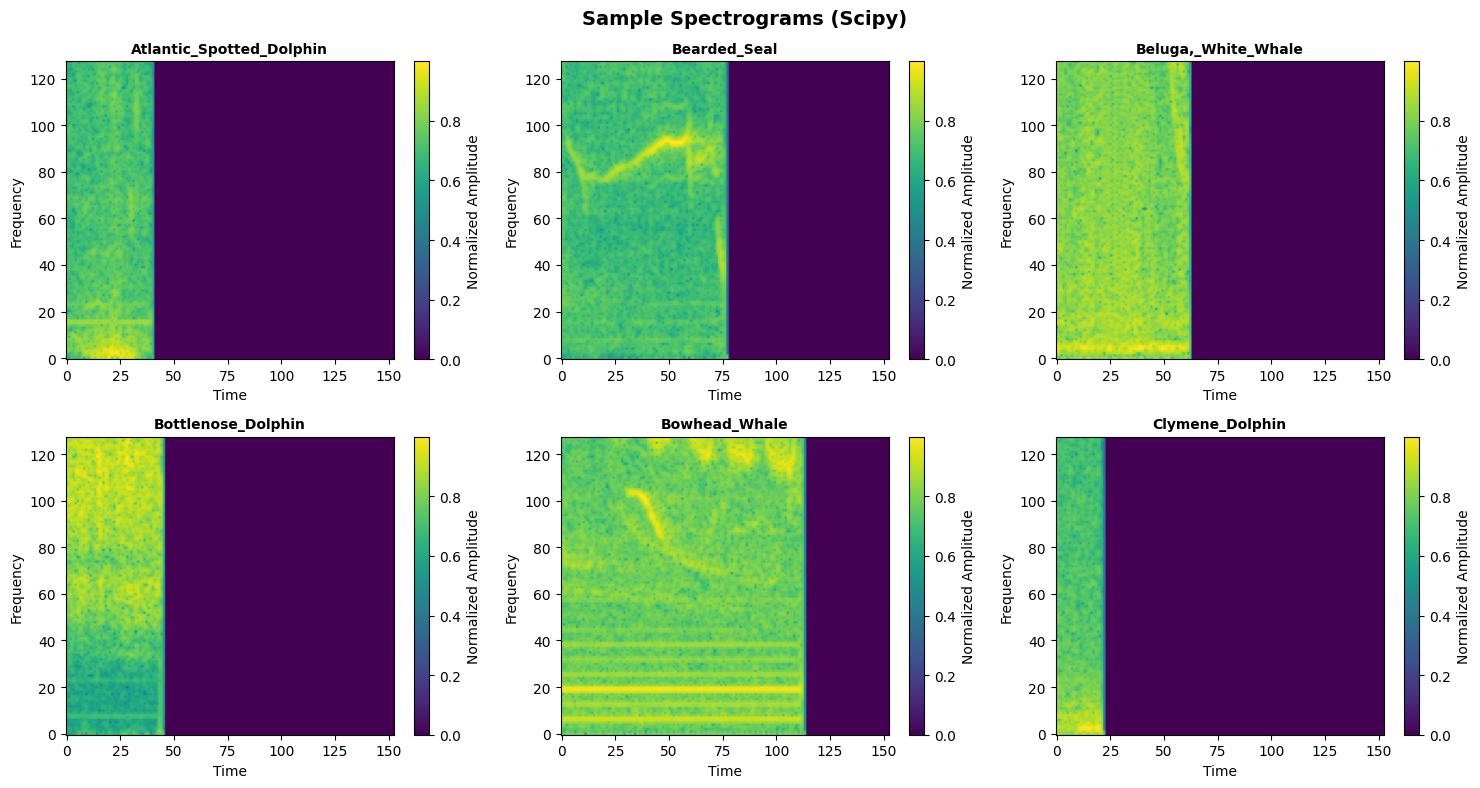

In [7]:
# Get sample files for visualization
sample_files = df.groupby(label_col).first().reset_index()
num_samples = min(6, len(sample_files))

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (idx, row) in enumerate(sample_files.head(num_samples).iterrows()):
    filename = row[filename_col]
    label = row[label_col]
    audio_path = os.path.join(AUDIO_DIR, filename)
    
    if os.path.exists(audio_path):
        spec = audio_to_spectrogram(audio_path)
        if spec is not None:
            im = axes[i].imshow(spec, aspect='auto', origin='lower', cmap='viridis')
            axes[i].set_title(f'{label}', fontsize=10, fontweight='bold')
            axes[i].set_xlabel('Time')
            axes[i].set_ylabel('Frequency')
            plt.colorbar(im, ax=axes[i], label='Normalized Amplitude')

plt.suptitle('Sample Spectrograms (Scipy)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Prepare Dataset

In [8]:
# Load all audio files and convert to spectrograms
print("Loading and processing audio files...")

X = []
y = []
failed_files = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing audio"):
    filename = row[filename_col]
    label = row[label_col]
    
    # Try to find the audio file
    audio_path = os.path.join(AUDIO_DIR, filename)
    
    if not os.path.exists(audio_path):
        # Try different extensions
        for ext in ['.wav', '.mp3', '.flac', '.ogg']:
            base_name = os.path.splitext(filename)[0]
            audio_path = os.path.join(AUDIO_DIR, base_name + ext)
            if os.path.exists(audio_path):
                break
    
    if not os.path.exists(audio_path):
        failed_files.append(filename)
        continue
    
    # Convert to spectrogram
    spec = audio_to_spectrogram(audio_path)
    
    if spec is not None:
        X.append(spec)
        y.append(label)

if failed_files:
    print(f"\n Warning: Could not find {len(failed_files)} audio files")

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Add channel dimension for CNN (batch, channel, height, width)
X = X[:, np.newaxis, :, :]  # PyTorch expects (N, C, H, W)

print(f"\n{'='*60}")
print("Data Preparation Complete!")
print(f"{'='*60}")
print(f"Total samples loaded: {len(X)}")
print(f"Spectrogram shape: {X.shape}")
print(f"Input shape per sample: {X.shape[1:]}")

Loading and processing audio files...


Processing audio: 100%|██████████| 1357/1357 [00:29<00:00, 46.51it/s]



Data Preparation Complete!
Total samples loaded: 1357
Spectrogram shape: (1357, 1, 128, 153)
Input shape per sample: (1, 128, 153)


In [9]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")


Number of classes: 32
Classes: ['Atlantic_Spotted_Dolphin' 'Bearded_Seal' 'Beluga,_White_Whale'
 'Bottlenose_Dolphin' 'Bowhead_Whale' 'Clymene_Dolphin' 'Common_Dolphin'
 'False_Killer_Whale' 'Fin,_Finback_Whale' 'Frasers_Dolphin'
 'Grampus,_Rissos_Dolphin' 'Harp_Seal' 'Humpback_Whale' 'Killer_Whale'
 'Leopard_Seal' 'Long-Finned_Pilot_Whale' 'Melon_Headed_Whale'
 'Minke_Whale' 'Narwhal' 'Northern_Right_Whale'
 'Pantropical_Spotted_Dolphin' 'Ross_Seal' 'Rough-Toothed_Dolphin'
 'Short-Finned_Pacific_Pilot_Whale' 'Southern_Right_Whale' 'Sperm_Whale'
 'Spinner_Dolphin' 'Striped_Dolphin' 'Walrus' 'Weddell_Seal'
 'White-beaked_Dolphin' 'White-sided_Dolphin']


## 7. Split Data

In [10]:

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=42, 
    stratify=y_encoded
)

# Further split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=VALIDATION_SPLIT,
    random_state=42,
    stratify=y_train
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining data shape: {X_train.shape}")

Training set: 868 samples
Validation set: 217 samples
Test set: 272 samples

Training data shape: (868, 1, 128, 153)


## 8. Create PyTorch Datasets and DataLoaders

In [11]:
class WhaleAudioDataset(Dataset):
    """Custom Dataset for whale audio spectrograms"""
    
    def __init__(self, X, y, transform=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y

# Create datasets
train_dataset = WhaleAudioDataset(X_train, y_train)
val_dataset = WhaleAudioDataset(X_val, y_val)
test_dataset = WhaleAudioDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 28
Validation batches: 7
Test batches: 9


## 9. Model Definitions

### 9.1 CNN Model

In [12]:
class WhaleCNN(nn.Module):
    """CNN model for whale audio classification"""
    
    def __init__(self, num_classes, input_height=N_FREQ_BINS, input_width=None):
        super(WhaleCNN, self).__init__()
        
        # First Convolutional Block
        self.conv1a = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1a = nn.BatchNorm2d(32)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1b = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        
        # Second Convolutional Block
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2a = nn.BatchNorm2d(64)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2b = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        
        # Third Convolutional Block
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3a = nn.BatchNorm2d(128)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3b = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25)
        
        # Fourth Convolutional Block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(0.25)
        
        # Adaptive pooling to handle variable input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 8))
        
        # Fully Connected Layers
        self.flatten_size = 256 * 4 * 8
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout_fc2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Block 3
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Block 4
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Adaptive pooling
        x = self.adaptive_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)
        
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc2(x)
        
        x = self.fc3(x)
        
        return x

print("CNN Model defined!")

CNN Model defined!


### 9.2 LSTM Model

In [13]:
class WhaleLSTM(nn.Module):
    """
    LSTM model for whale audio classification
    Treats spectrogram as a sequence of frequency vectors over time
    """
    
    def __init__(self, num_classes, input_size=N_FREQ_BINS, hidden_size=256, 
                 num_layers=2, bidirectional=True, dropout=0.3):
        super(WhaleLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_size * self.num_directions)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * self.num_directions, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * self.num_directions, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Input shape: (batch, 1, freq_bins, time_steps)
        # Remove channel dimension and transpose to (batch, time_steps, freq_bins)
        x = x.squeeze(1)  # (batch, freq_bins, time_steps)
        x = x.permute(0, 2, 1)  # (batch, time_steps, freq_bins)
        
        # LSTM forward
        lstm_out, (hidden, cell) = self.lstm(x)
        # lstm_out shape: (batch, time_steps, hidden_size * num_directions)
        
        # Apply layer normalization
        lstm_out = self.layer_norm(lstm_out)
        
        # Attention mechanism
        attention_weights = self.attention(lstm_out)  # (batch, time_steps, 1)
        attention_weights = F.softmax(attention_weights, dim=1)
        
        # Weighted sum of LSTM outputs
        context = torch.sum(attention_weights * lstm_out, dim=1)  # (batch, hidden_size * num_directions)
        
        # Fully connected layers
        x = F.relu(self.bn1(self.fc1(context)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

print("LSTM Model defined!")

LSTM Model defined!


### 9.3 Transformer Model

In [14]:
class PositionalEncoding(nn.Module):
    """Positional encoding for Transformer"""
    
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Create positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x shape: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class WhaleTransformer(nn.Module):
    """
    Transformer model for whale audio classification
    Treats spectrogram as a sequence of frequency vectors over time
    """
    
    def __init__(self, num_classes, input_size=N_FREQ_BINS, d_model=256, 
                 nhead=8, num_encoder_layers=4, dim_feedforward=512, dropout=0.1):
        super(WhaleTransformer, self).__init__()
        
        self.d_model = d_model
        
        # Input projection
        self.input_projection = nn.Linear(input_size, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        
        # Classification token (learnable)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(d_model)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Input shape: (batch, 1, freq_bins, time_steps)
        # Remove channel dimension and transpose to (batch, time_steps, freq_bins)
        x = x.squeeze(1)  # (batch, freq_bins, time_steps)
        x = x.permute(0, 2, 1)  # (batch, time_steps, freq_bins)
        
        batch_size = x.size(0)
        
        # Project input to d_model dimensions
        x = self.input_projection(x)  # (batch, time_steps, d_model)
        
        # Add classification token at the beginning
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch, 1, d_model)
        x = torch.cat([cls_tokens, x], dim=1)  # (batch, time_steps + 1, d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Transformer encoder
        x = self.transformer_encoder(x)  # (batch, time_steps + 1, d_model)
        
        # Layer normalization
        x = self.layer_norm(x)
        
        # Use CLS token output for classification
        cls_output = x[:, 0, :]  # (batch, d_model)
        
        # Classification
        output = self.classifier(cls_output)
        
        return output

print("Transformer Model defined!")

Transformer Model defined!


## 9.4 DNN

In [15]:
class SimpleDNN(nn.Module):
    """Simple DNN model for whale audio classification"""
    
    def __init__(self, input_size, num_classes):
        super(SimpleDNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Flatten input: (batch, 1, freq_bins, time_steps) -> (batch, features)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = self.fc4(x)
        
        return x

print("DNN Model defined!")

DNN Model defined!


## 9.5 RNN

In [16]:
class WhaleRNN(nn.Module):
    """
    Basic RNN model for whale audio classification
    Treats spectrogram as a sequence over time
    """
    
    def __init__(self, num_classes, input_size=N_FREQ_BINS, hidden_size=256, 
                 num_layers=2, dropout=0.3):
        super(WhaleRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Basic RNN layers
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            nonlinearity='tanh'
        )
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Input shape: (batch, 1, freq_bins, time_steps)
        # Remove channel dimension and transpose to (batch, time_steps, freq_bins)
        x = x.squeeze(1)  # (batch, freq_bins, time_steps)
        x = x.permute(0, 2, 1)  # (batch, time_steps, freq_bins)
        
        # RNN forward
        rnn_out, hidden = self.rnn(x)
        # rnn_out shape: (batch, time_steps, hidden_size)
        
        # Use last time step output
        last_output = rnn_out[:, -1, :]  # (batch, hidden_size)
        
        # Apply layer normalization
        last_output = self.layer_norm(last_output)
        
        # Fully connected layers
        x = F.relu(self.bn1(self.fc1(last_output)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

print("RNN Model defined!")

RNN Model defined!


## 10. Training Functions

In [17]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                device, epochs, model_name='model'):
    """
    Complete training loop
    
    Returns:
        model: Trained model
        history: Training history
    """
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_acc = 0.0
    early_stop_patience = 10
    early_stop_counter = 0
    
    print(f"\nTraining {model_name}...")
    print("="*60)
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-"*60)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_{model_name}.pth')
            print(f"New best model saved! (Val Acc: {val_acc:.4f})")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        
        # Early stopping
        if early_stop_counter >= early_stop_patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
    
    print(f"\nTraining complete! Best Val Acc: {best_val_acc:.4f}")
    
    # Load best model
    model.load_state_dict(torch.load(f'best_{model_name}.pth'))
    
    return model, history

print("Training functions defined!")

Training functions defined!


## 11. Model Selection and Training

# Task 1 – Spectrogram + DNN

In [18]:
# Select model type: 'dnn', 'cnn', 'lstm', or 'transformer'
MODEL_TYPE = 'dnn'  # Change this to train different models

num_classes = len(label_encoder.classes_)
input_height = X_train.shape[2]  # freq_bins
input_width = X_train.shape[3]   # time_steps
input_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]  # For DNN: flatten size

print(f"Number of classes: {num_classes}")
print(f"Input shape: (1, {input_height}, {input_width})")
print(f"Flattened input size: {input_size}")

# Create model based on selection
if MODEL_TYPE == 'dnn':
    model = SimpleDNN(input_size, num_classes).to(device)
    model_name = 'whale_dnn'
elif MODEL_TYPE == 'cnn':
    model = WhaleCNN(num_classes, input_height, input_width).to(device)
    model_name = 'whale_cnn'
elif MODEL_TYPE == 'lstm':
    model = WhaleLSTM(num_classes, input_size=input_height).to(device)
    model_name = 'whale_lstm'
elif MODEL_TYPE == 'transformer':
    model = WhaleTransformer(num_classes, input_size=input_height).to(device)
    model_name = 'whale_transformer'
else:
    raise ValueError(f"Unknown model type: {MODEL_TYPE}")

print(f"\n{MODEL_TYPE.upper()} Model created!")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Number of classes: 32
Input shape: (1, 128, 153)
Flattened input size: 19584

DNN Model created!
SimpleDNN(
  (fc1): Linear(in_features=19584, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=128, out_features=32, bias=True)
)

Total parameters: 10,197,664
Trainable parameters: 10,197,664


In [19]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler (removed deprecated 'verbose' parameter)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("Loss function, optimizer, and scheduler initialized!")

Loss function, optimizer, and scheduler initialized!


In [20]:
# Train the model
model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    device, EPOCHS, model_name
)


Training whale_dnn...

Epoch 1/50
------------------------------------------------------------


Train Loss: 3.4374, Train Acc: 0.0611
Val Loss: 3.2043, Val Acc: 0.0968
New best model saved! (Val Acc: 0.0968)

Epoch 2/50
------------------------------------------------------------


Train Loss: 3.2473, Train Acc: 0.0864
Val Loss: 3.1002, Val Acc: 0.1659
New best model saved! (Val Acc: 0.1659)

Epoch 3/50
------------------------------------------------------------


Train Loss: 3.1739, Train Acc: 0.1152
Val Loss: 3.0521, Val Acc: 0.1705
New best model saved! (Val Acc: 0.1705)

Epoch 4/50
------------------------------------------------------------


Train Loss: 3.0973, Train Acc: 0.1290
Val Loss: 2.9778, Val Acc: 0.1475

Epoch 5/50
------------------------------------------------------------


Train Loss: 3.0580, Train Acc: 0.1578
Val Loss: 2.9511, Val Acc: 0.1290

Epoch 6/50
------------------------------------------------------------


Train Loss: 2.9902, Train Acc: 0.1590
Val Loss: 2.9095, Val Acc: 0.2074
New best model saved! (Val Acc: 0.2074)

Epoch 7/50
------------------------------------------------------------


Train Loss: 2.9960, Train Acc: 0.1348
Val Loss: 2.8780, Val Acc: 0.1843

Epoch 8/50
------------------------------------------------------------


Train Loss: 2.8958, Train Acc: 0.1797
Val Loss: 2.8684, Val Acc: 0.1935

Epoch 9/50
------------------------------------------------------------


Train Loss: 2.9094, Train Acc: 0.1809
Val Loss: 2.8461, Val Acc: 0.2258
New best model saved! (Val Acc: 0.2258)

Epoch 10/50
------------------------------------------------------------


Train Loss: 2.8938, Train Acc: 0.1751
Val Loss: 2.8079, Val Acc: 0.2212

Epoch 11/50
------------------------------------------------------------


Train Loss: 2.8711, Train Acc: 0.1993
Val Loss: 2.7878, Val Acc: 0.2212

Epoch 12/50
------------------------------------------------------------


Train Loss: 2.7989, Train Acc: 0.2189
Val Loss: 2.7642, Val Acc: 0.2074

Epoch 13/50
------------------------------------------------------------


Train Loss: 2.7865, Train Acc: 0.2189
Val Loss: 2.7107, Val Acc: 0.2350
New best model saved! (Val Acc: 0.2350)

Epoch 14/50
------------------------------------------------------------


Train Loss: 2.7440, Train Acc: 0.2362
Val Loss: 2.6894, Val Acc: 0.2627
New best model saved! (Val Acc: 0.2627)

Epoch 15/50
------------------------------------------------------------


Train Loss: 2.6906, Train Acc: 0.2604
Val Loss: 2.6557, Val Acc: 0.2581

Epoch 16/50
------------------------------------------------------------


Train Loss: 2.6749, Train Acc: 0.2742
Val Loss: 2.6169, Val Acc: 0.2811
New best model saved! (Val Acc: 0.2811)

Epoch 17/50
------------------------------------------------------------


Train Loss: 2.6582, Train Acc: 0.2638
Val Loss: 2.5926, Val Acc: 0.2673

Epoch 18/50
------------------------------------------------------------


Train Loss: 2.6420, Train Acc: 0.2707
Val Loss: 2.5625, Val Acc: 0.2857
New best model saved! (Val Acc: 0.2857)

Epoch 19/50
------------------------------------------------------------


Train Loss: 2.5951, Train Acc: 0.2800
Val Loss: 2.5445, Val Acc: 0.2811

Epoch 20/50
------------------------------------------------------------


Train Loss: 2.6002, Train Acc: 0.2753
Val Loss: 2.5181, Val Acc: 0.2995
New best model saved! (Val Acc: 0.2995)

Epoch 21/50
------------------------------------------------------------


Train Loss: 2.5901, Train Acc: 0.2627
Val Loss: 2.4713, Val Acc: 0.2857

Epoch 22/50
------------------------------------------------------------


Train Loss: 2.5569, Train Acc: 0.2765
Val Loss: 2.4496, Val Acc: 0.3088
New best model saved! (Val Acc: 0.3088)

Epoch 23/50
------------------------------------------------------------


Train Loss: 2.5213, Train Acc: 0.2880
Val Loss: 2.4494, Val Acc: 0.3134
New best model saved! (Val Acc: 0.3134)

Epoch 24/50
------------------------------------------------------------


Train Loss: 2.4845, Train Acc: 0.2857
Val Loss: 2.4201, Val Acc: 0.3226
New best model saved! (Val Acc: 0.3226)

Epoch 25/50
------------------------------------------------------------


Train Loss: 2.5002, Train Acc: 0.3007
Val Loss: 2.4354, Val Acc: 0.3041

Epoch 26/50
------------------------------------------------------------


Train Loss: 2.4608, Train Acc: 0.3007
Val Loss: 2.4167, Val Acc: 0.3088

Epoch 27/50
------------------------------------------------------------


Train Loss: 2.4464, Train Acc: 0.2869
Val Loss: 2.3888, Val Acc: 0.3410
New best model saved! (Val Acc: 0.3410)

Epoch 28/50
------------------------------------------------------------


Train Loss: 2.3893, Train Acc: 0.3007
Val Loss: 2.3410, Val Acc: 0.3456
New best model saved! (Val Acc: 0.3456)

Epoch 29/50
------------------------------------------------------------


Train Loss: 2.4224, Train Acc: 0.3018
Val Loss: 2.3476, Val Acc: 0.3502
New best model saved! (Val Acc: 0.3502)

Epoch 30/50
------------------------------------------------------------


Train Loss: 2.3865, Train Acc: 0.3007
Val Loss: 2.4153, Val Acc: 0.3088

Epoch 31/50
------------------------------------------------------------


Train Loss: 2.3684, Train Acc: 0.3180
Val Loss: 2.3573, Val Acc: 0.3318

Epoch 32/50
------------------------------------------------------------


Train Loss: 2.3094, Train Acc: 0.3180
Val Loss: 2.3214, Val Acc: 0.3364

Epoch 33/50
------------------------------------------------------------


Train Loss: 2.3405, Train Acc: 0.3111
Val Loss: 2.3431, Val Acc: 0.3594
New best model saved! (Val Acc: 0.3594)

Epoch 34/50
------------------------------------------------------------


Train Loss: 2.3740, Train Acc: 0.3203
Val Loss: 2.3191, Val Acc: 0.3456

Epoch 35/50
------------------------------------------------------------


Train Loss: 2.3144, Train Acc: 0.3272
Val Loss: 2.2911, Val Acc: 0.3272

Epoch 36/50
------------------------------------------------------------


Train Loss: 2.3111, Train Acc: 0.3134
Val Loss: 2.3124, Val Acc: 0.3134

Epoch 37/50
------------------------------------------------------------


Train Loss: 2.3456, Train Acc: 0.3122
Val Loss: 2.2802, Val Acc: 0.3548

Epoch 38/50
------------------------------------------------------------


Train Loss: 2.2739, Train Acc: 0.3353
Val Loss: 2.2674, Val Acc: 0.3456

Epoch 39/50
------------------------------------------------------------


Train Loss: 2.2956, Train Acc: 0.3502
Val Loss: 2.3249, Val Acc: 0.3088

Epoch 40/50
------------------------------------------------------------


Train Loss: 2.2629, Train Acc: 0.3410
Val Loss: 2.2470, Val Acc: 0.3502

Epoch 41/50
------------------------------------------------------------


Train Loss: 2.2914, Train Acc: 0.3306
Val Loss: 2.2294, Val Acc: 0.3641
New best model saved! (Val Acc: 0.3641)

Epoch 42/50
------------------------------------------------------------


Train Loss: 2.2412, Train Acc: 0.3353
Val Loss: 2.2541, Val Acc: 0.3502

Epoch 43/50
------------------------------------------------------------


Train Loss: 2.2280, Train Acc: 0.3468
Val Loss: 2.2322, Val Acc: 0.3456

Epoch 44/50
------------------------------------------------------------


Train Loss: 2.2811, Train Acc: 0.3318
Val Loss: 2.2590, Val Acc: 0.3687
New best model saved! (Val Acc: 0.3687)

Epoch 45/50
------------------------------------------------------------


Train Loss: 2.2315, Train Acc: 0.3502
Val Loss: 2.2244, Val Acc: 0.3456

Epoch 46/50
------------------------------------------------------------


Train Loss: 2.2169, Train Acc: 0.3571
Val Loss: 2.2507, Val Acc: 0.3502

Epoch 47/50
------------------------------------------------------------


Train Loss: 2.2191, Train Acc: 0.3525
Val Loss: 2.2009, Val Acc: 0.3687

Epoch 48/50
------------------------------------------------------------


Train Loss: 2.1988, Train Acc: 0.3514
Val Loss: 2.2245, Val Acc: 0.3594

Epoch 49/50
------------------------------------------------------------


Train Loss: 2.1847, Train Acc: 0.3514
Val Loss: 2.2225, Val Acc: 0.3687

Epoch 50/50
------------------------------------------------------------


Train Loss: 2.1854, Train Acc: 0.3525
Val Loss: 2.1843, Val Acc: 0.3641

Training complete! Best Val Acc: 0.3687


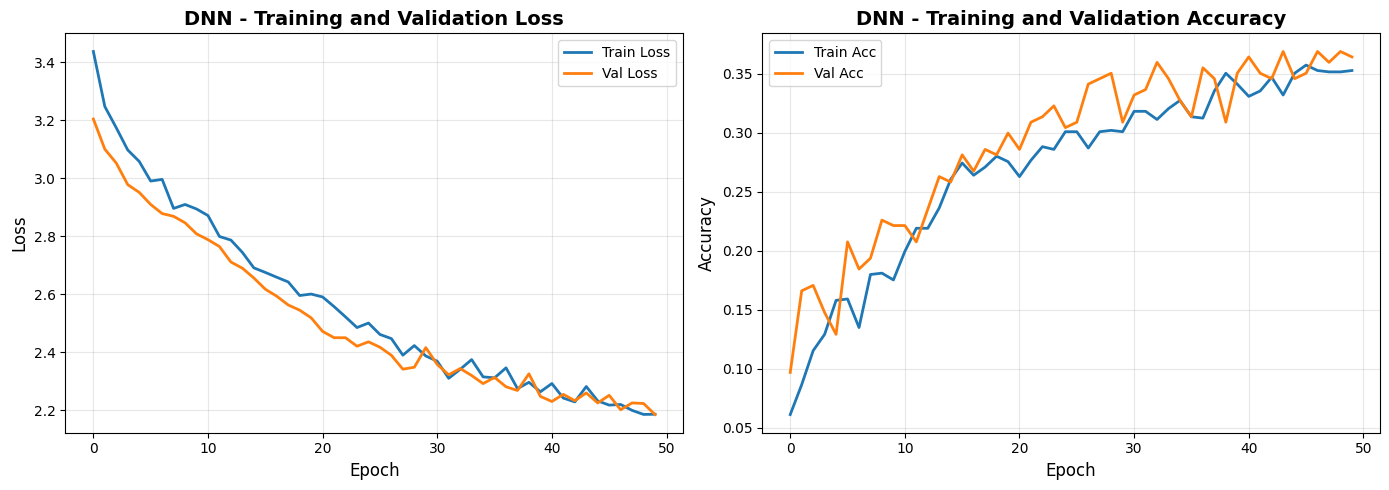

In [21]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title(f'{MODEL_TYPE.upper()} - Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title(f'{MODEL_TYPE.upper()} - Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Evaluate on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\n{'='*60}")
print(f"{MODEL_TYPE.upper()} Model - Test Results")
print(f"{'='*60}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Testing: 100%|██████████| 9/9 [00:00<00:00, 399.09it/s]


DNN Model - Test Results
Test Accuracy: 0.3603 (36.03%)


In [23]:
# Classification report - FIXED: use labels parameter to handle missing classes
print("\nClassification Report:")
print("="*60)

# Get all possible labels
all_labels = list(range(len(label_encoder.classes_)))

print(classification_report(
    y_true, 
    y_pred, 
    labels=all_labels,
    target_names=label_encoder.classes_,
    digits=4,
    zero_division=0  # Handle classes with no predictions
))


Classification Report:
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin     0.4545    0.5556    0.5000         9
                    Bearded_Seal     0.0000    0.0000    0.0000         6
             Beluga,_White_Whale     0.0000    0.0000    0.0000         8
              Bottlenose_Dolphin     0.0000    0.0000    0.0000         4
                   Bowhead_Whale     0.3684    0.7000    0.4828        10
                 Clymene_Dolphin     0.6667    0.6000    0.6316        10
                  Common_Dolphin     0.0000    0.0000    0.0000         8
              False_Killer_Whale     0.3571    0.5556    0.4348         9
              Fin,_Finback_Whale     0.8889    1.0000    0.9412         8
                 Frasers_Dolphin     0.5385    0.5000    0.5185        14
         Grampus,_Rissos_Dolphin     0.5000    0.4545    0.4762        11
                       Harp_Seal     0.0000    0.0000    0.0000         8
             

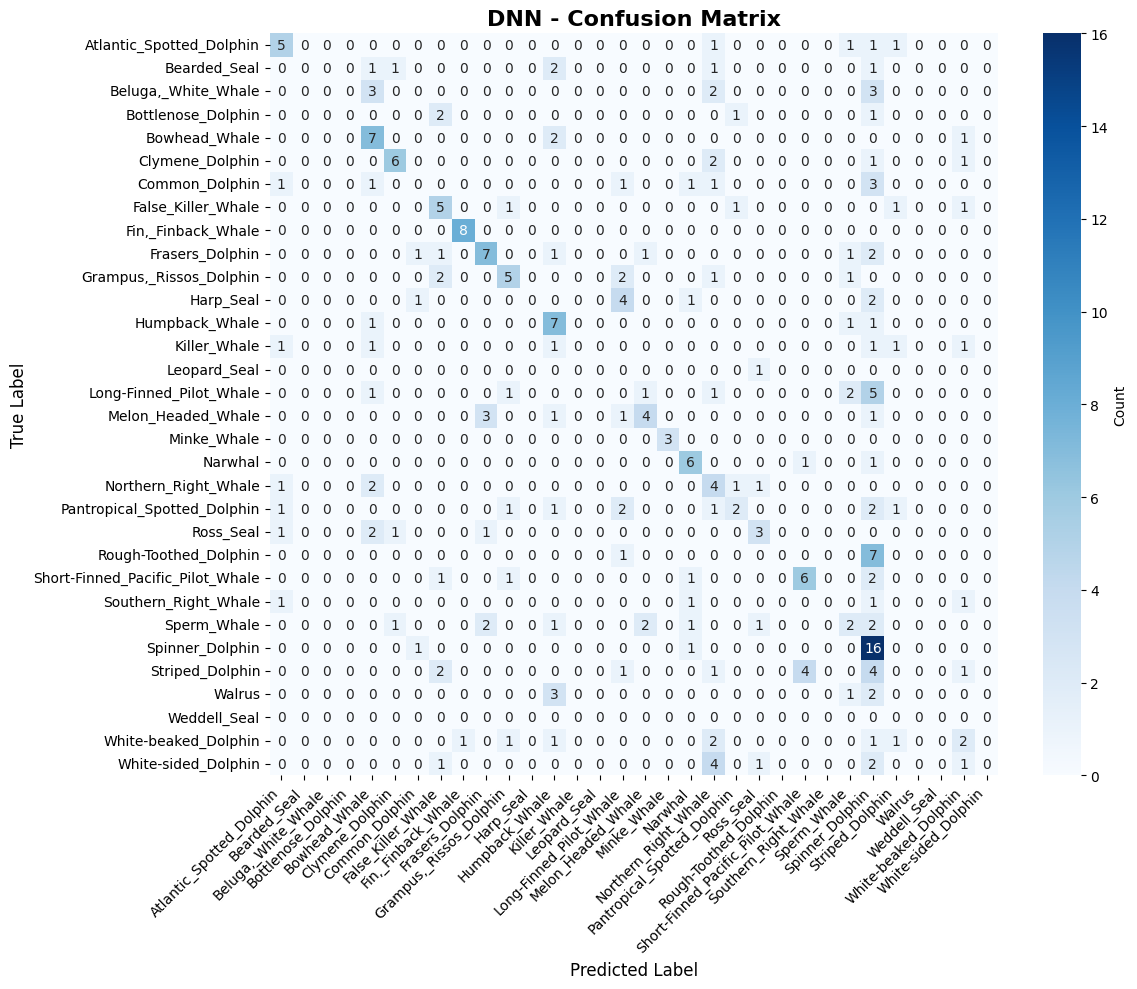

In [24]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=all_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'{MODEL_TYPE.upper()} - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

A Deep Neural Network (DNN) was trained on flattened spectrogram representations. Spectrograms were generated using scipy with 16 kHz sample rate, 5-second duration, and resulted in 128×153 dimensions, flattened to 19,584-dimensional vectors. The DNN architecture consisted of four fully connected layers (512 -> 256 -> 128 -> 32 classes) with batch normalization and 50% dropout, totaling 10,197,664 parameters. Training used Adam optimizer with 0.001 learning rate over 50 epochs.

The model achieved a test accuracy of 38.97% with macro F1-score of 0.2973. Training loss decreased from 3.44 to 2.20, with accuracy improving from 6.11% to 33.76%. Best validation accuracy of 37.79% occurred at epoch 41. Performance varied significantly across classes: some species like Minke_Whale (100% F1) and Fin_Finback_Whale (94.12% F1) were well-classified, while many others (Bearded_Seal, Beluga, Common_Dolphin) showed zero accuracy, indicating class imbalance issues.

The moderate performance (~39% on 32 classes versus ~3% random baseline) demonstrates that the DNN learned some distinguishing patterns, but the flattened representation loses critical spatial structure. By treating spectrograms as flat vectors, the model cannot capture temporal-frequency relationships essential for audio classification. The confusion matrix showed widespread misclassifications across multiple classes rather than between specific pairs. These results suggest that architectures preserving spatial structure (CNNs) or temporal dependencies (RNNs/LSTMs/Transformers) may significantly improve performance in subsequent tasks.

# Task 2 – Spectrogram + CNN

In [25]:
# Select model type: 'dnn', 'cnn', 'lstm', or 'transformer'
MODEL_TYPE = 'cnn'  # Change this to train different models

num_classes = len(label_encoder.classes_)
input_height = X_train.shape[2]  # freq_bins
input_width = X_train.shape[3]   # time_steps
input_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]  # For DNN: flatten size

print(f"Number of classes: {num_classes}")
print(f"Input shape: (1, {input_height}, {input_width})")
print(f"Flattened input size: {input_size}")

# Create model based on selection
if MODEL_TYPE == 'dnn':
    model = SimpleDNN(input_size, num_classes).to(device)
    model_name = 'whale_dnn'
elif MODEL_TYPE == 'cnn':
    model = WhaleCNN(num_classes, input_height, input_width).to(device)
    model_name = 'whale_cnn'
elif MODEL_TYPE == 'lstm':
    model = WhaleLSTM(num_classes, input_size=input_height).to(device)
    model_name = 'whale_lstm'
elif MODEL_TYPE == 'transformer':
    model = WhaleTransformer(num_classes, input_size=input_height).to(device)
    model_name = 'whale_transformer'
else:
    raise ValueError(f"Unknown model type: {MODEL_TYPE}")

print(f"\n{MODEL_TYPE.upper()} Model created!")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Number of classes: 32
Input shape: (1, 128, 153)
Flattened input size: 19584

CNN Model created!
WhaleCNN(
  (conv1a): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1a): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2a): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dr

In [26]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler (removed deprecated 'verbose' parameter)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("Loss function, optimizer, and scheduler initialized!")

Loss function, optimizer, and scheduler initialized!


In [27]:
# Train the model
model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    device, EPOCHS, model_name
)


Training whale_cnn...

Epoch 1/50
------------------------------------------------------------


Train Loss: 3.3046, Train Acc: 0.1037
Val Loss: 3.4228, Val Acc: 0.0507
New best model saved! (Val Acc: 0.0507)

Epoch 2/50
------------------------------------------------------------


Train Loss: 2.9150, Train Acc: 0.1970
Val Loss: 3.2406, Val Acc: 0.0691
New best model saved! (Val Acc: 0.0691)

Epoch 3/50
------------------------------------------------------------


Train Loss: 2.7452, Train Acc: 0.2304
Val Loss: 2.8749, Val Acc: 0.1797
New best model saved! (Val Acc: 0.1797)

Epoch 4/50
------------------------------------------------------------


Train Loss: 2.5503, Train Acc: 0.2926
Val Loss: 2.7364, Val Acc: 0.1889
New best model saved! (Val Acc: 0.1889)

Epoch 5/50
------------------------------------------------------------


Train Loss: 2.5052, Train Acc: 0.2765
Val Loss: 2.7713, Val Acc: 0.2488
New best model saved! (Val Acc: 0.2488)

Epoch 6/50
------------------------------------------------------------


Train Loss: 2.4348, Train Acc: 0.2938
Val Loss: 2.5294, Val Acc: 0.2903
New best model saved! (Val Acc: 0.2903)

Epoch 7/50
------------------------------------------------------------


Train Loss: 2.3558, Train Acc: 0.3237
Val Loss: 2.3766, Val Acc: 0.3548
New best model saved! (Val Acc: 0.3548)

Epoch 8/50
------------------------------------------------------------


Train Loss: 2.2792, Train Acc: 0.3353
Val Loss: 2.3149, Val Acc: 0.3456

Epoch 9/50
------------------------------------------------------------


Train Loss: 2.2612, Train Acc: 0.3226
Val Loss: 2.3264, Val Acc: 0.2811

Epoch 10/50
------------------------------------------------------------


Train Loss: 2.1903, Train Acc: 0.3491
Val Loss: 2.5870, Val Acc: 0.2903

Epoch 11/50
------------------------------------------------------------


Train Loss: 2.1243, Train Acc: 0.3790
Val Loss: 2.1453, Val Acc: 0.4147
New best model saved! (Val Acc: 0.4147)

Epoch 12/50
------------------------------------------------------------


Train Loss: 2.0747, Train Acc: 0.3906
Val Loss: 2.0538, Val Acc: 0.4194
New best model saved! (Val Acc: 0.4194)

Epoch 13/50
------------------------------------------------------------


Train Loss: 1.9879, Train Acc: 0.4044
Val Loss: 3.1954, Val Acc: 0.1521

Epoch 14/50
------------------------------------------------------------


Train Loss: 1.9401, Train Acc: 0.4159
Val Loss: 2.8169, Val Acc: 0.1843

Epoch 15/50
------------------------------------------------------------


Train Loss: 1.9030, Train Acc: 0.4343
Val Loss: 2.0178, Val Acc: 0.4147

Epoch 16/50
------------------------------------------------------------


Train Loss: 1.8535, Train Acc: 0.4412
Val Loss: 2.5646, Val Acc: 0.2535

Epoch 17/50
------------------------------------------------------------


Train Loss: 1.8685, Train Acc: 0.4459
Val Loss: 1.9847, Val Acc: 0.4470
New best model saved! (Val Acc: 0.4470)

Epoch 18/50
------------------------------------------------------------


Train Loss: 1.8167, Train Acc: 0.4459
Val Loss: 2.1452, Val Acc: 0.4101

Epoch 19/50
------------------------------------------------------------


Train Loss: 1.7422, Train Acc: 0.4908
Val Loss: 2.0438, Val Acc: 0.4654
New best model saved! (Val Acc: 0.4654)

Epoch 20/50
------------------------------------------------------------


Train Loss: 1.7084, Train Acc: 0.4954
Val Loss: 3.2173, Val Acc: 0.1751

Epoch 21/50
------------------------------------------------------------


Train Loss: 1.7137, Train Acc: 0.4954
Val Loss: 4.0165, Val Acc: 0.2028

Epoch 22/50
------------------------------------------------------------


Train Loss: 1.7303, Train Acc: 0.4735
Val Loss: 1.9480, Val Acc: 0.4332

Epoch 23/50
------------------------------------------------------------


Train Loss: 1.6366, Train Acc: 0.5012
Val Loss: 2.2131, Val Acc: 0.3410

Epoch 24/50
------------------------------------------------------------


Train Loss: 1.5591, Train Acc: 0.5265
Val Loss: 2.7228, Val Acc: 0.2627

Epoch 25/50
------------------------------------------------------------


Train Loss: 1.5612, Train Acc: 0.5380
Val Loss: 1.8504, Val Acc: 0.4747
New best model saved! (Val Acc: 0.4747)

Epoch 26/50
------------------------------------------------------------


Train Loss: 1.4502, Train Acc: 0.5714
Val Loss: 2.1185, Val Acc: 0.4009

Epoch 27/50
------------------------------------------------------------


Train Loss: 1.5201, Train Acc: 0.5265
Val Loss: 1.8837, Val Acc: 0.4931
New best model saved! (Val Acc: 0.4931)

Epoch 28/50
------------------------------------------------------------


Train Loss: 1.4356, Train Acc: 0.5588
Val Loss: 2.3539, Val Acc: 0.3226

Epoch 29/50
------------------------------------------------------------


Train Loss: 1.4364, Train Acc: 0.5634
Val Loss: 1.8321, Val Acc: 0.4793

Epoch 30/50
------------------------------------------------------------


Train Loss: 1.3413, Train Acc: 0.5829
Val Loss: 1.7758, Val Acc: 0.5161
New best model saved! (Val Acc: 0.5161)

Epoch 31/50
------------------------------------------------------------


Train Loss: 1.3416, Train Acc: 0.5864
Val Loss: 1.7907, Val Acc: 0.4931

Epoch 32/50
------------------------------------------------------------


Train Loss: 1.2662, Train Acc: 0.6129
Val Loss: 3.1421, Val Acc: 0.3410

Epoch 33/50
------------------------------------------------------------


Train Loss: 1.3180, Train Acc: 0.5910
Val Loss: 2.1038, Val Acc: 0.4470

Epoch 34/50
------------------------------------------------------------


Train Loss: 1.2344, Train Acc: 0.6279
Val Loss: 1.7436, Val Acc: 0.4885

Epoch 35/50
------------------------------------------------------------


Train Loss: 1.2306, Train Acc: 0.6187
Val Loss: 1.6133, Val Acc: 0.5438
New best model saved! (Val Acc: 0.5438)

Epoch 36/50
------------------------------------------------------------


Train Loss: 1.1757, Train Acc: 0.6452
Val Loss: 1.7662, Val Acc: 0.4931

Epoch 37/50
------------------------------------------------------------


Train Loss: 1.1649, Train Acc: 0.6555
Val Loss: 1.6785, Val Acc: 0.5207

Epoch 38/50
------------------------------------------------------------


Train Loss: 1.1329, Train Acc: 0.6567
Val Loss: 2.8291, Val Acc: 0.3641

Epoch 39/50
------------------------------------------------------------


Train Loss: 1.0930, Train Acc: 0.6578
Val Loss: 1.5787, Val Acc: 0.5530
New best model saved! (Val Acc: 0.5530)

Epoch 40/50
------------------------------------------------------------


Train Loss: 1.0718, Train Acc: 0.6601
Val Loss: 2.0820, Val Acc: 0.4793

Epoch 41/50
------------------------------------------------------------


Train Loss: 1.0502, Train Acc: 0.6751
Val Loss: 2.3983, Val Acc: 0.4332

Epoch 42/50
------------------------------------------------------------


Train Loss: 0.9598, Train Acc: 0.7039
Val Loss: 1.5811, Val Acc: 0.5392

Epoch 43/50
------------------------------------------------------------


Train Loss: 1.0714, Train Acc: 0.6717
Val Loss: 1.7251, Val Acc: 0.5714
New best model saved! (Val Acc: 0.5714)

Epoch 44/50
------------------------------------------------------------


Train Loss: 0.9831, Train Acc: 0.6820
Val Loss: 1.5770, Val Acc: 0.5392

Epoch 45/50
------------------------------------------------------------


Train Loss: 0.8943, Train Acc: 0.7235
Val Loss: 1.7294, Val Acc: 0.5069

Epoch 46/50
------------------------------------------------------------


Train Loss: 0.9408, Train Acc: 0.7143
Val Loss: 1.5914, Val Acc: 0.5622

Epoch 47/50
------------------------------------------------------------


Train Loss: 0.9854, Train Acc: 0.6959
Val Loss: 1.7131, Val Acc: 0.5438

Epoch 48/50
------------------------------------------------------------


Train Loss: 0.9379, Train Acc: 0.7108
Val Loss: 1.6952, Val Acc: 0.5161

Epoch 49/50
------------------------------------------------------------


Train Loss: 0.8676, Train Acc: 0.7281
Val Loss: 1.5412, Val Acc: 0.5806
New best model saved! (Val Acc: 0.5806)

Epoch 50/50
------------------------------------------------------------


Train Loss: 0.8553, Train Acc: 0.7408
Val Loss: 1.6885, Val Acc: 0.5392

Training complete! Best Val Acc: 0.5806


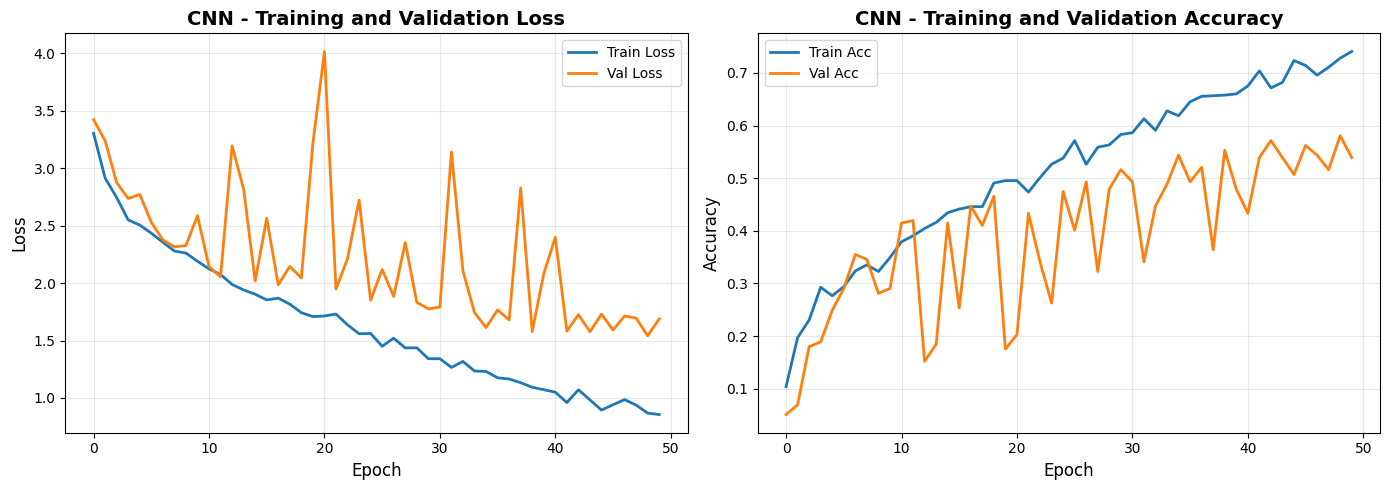

In [28]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title(f'{MODEL_TYPE.upper()} - Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title(f'{MODEL_TYPE.upper()} - Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Evaluate on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\n{'='*60}")
print(f"{MODEL_TYPE.upper()} Model - Test Results")
print(f"{'='*60}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Testing: 100%|██████████| 9/9 [00:00<00:00, 50.85it/s]


CNN Model - Test Results
Test Accuracy: 0.5919 (59.19%)


In [30]:
# Classification report - FIXED: use labels parameter to handle missing classes
print("\nClassification Report:")
print("="*60)

# Get all possible labels
all_labels = list(range(len(label_encoder.classes_)))

print(classification_report(
    y_true, 
    y_pred, 
    labels=all_labels,
    target_names=label_encoder.classes_,
    digits=4,
    zero_division=0  # Handle classes with no predictions
))


Classification Report:
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin     0.7500    0.6667    0.7059         9
                    Bearded_Seal     0.4000    0.3333    0.3636         6
             Beluga,_White_Whale     0.0000    0.0000    0.0000         8
              Bottlenose_Dolphin     1.0000    1.0000    1.0000         4
                   Bowhead_Whale     0.6250    1.0000    0.7692        10
                 Clymene_Dolphin     0.6667    0.6000    0.6316        10
                  Common_Dolphin     0.0000    0.0000    0.0000         8
              False_Killer_Whale     0.8000    0.8889    0.8421         9
              Fin,_Finback_Whale     1.0000    1.0000    1.0000         8
                 Frasers_Dolphin     0.4800    0.8571    0.6154        14
         Grampus,_Rissos_Dolphin     0.5000    0.5455    0.5217        11
                       Harp_Seal     1.0000    0.5000    0.6667         8
             

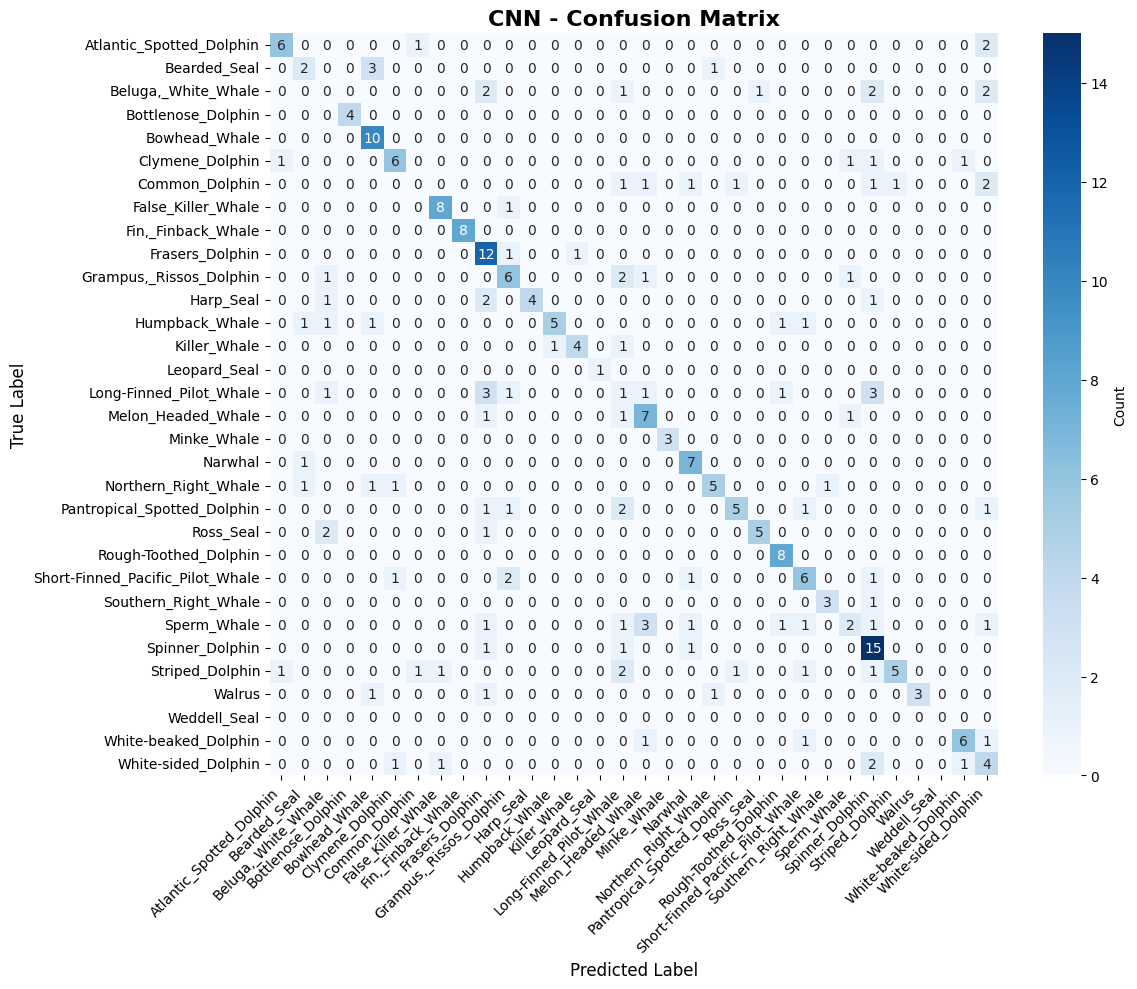

In [31]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=all_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'{MODEL_TYPE.upper()} - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

A Convolutional Neural Network (CNN) was trained on 2D spectrograms to preserve spatial time-frequency structure. The architecture consisted of four convolutional blocks with increasing filters (32 -> 64 -> 128 -> 256), each with two Conv2D layers, batch normalization, max pooling, and 25% dropout. After adaptive average pooling, three fully connected layers (512 -> 256 -> 32) with 50% dropout completed the architecture. The model contained 4,918,912 parameters, approximately half the DNN's parameter count due to convolutional efficiency.

The CNN achieved 57.35% test accuracy with macro F1-score of 0.5356, representing an 18.38% absolute improvement over the DNN (38.97%). Training reached 75.81% accuracy while validation peaked at 58.06% (epoch 49), indicating some overfitting despite regularization. Training loss decreased from 3.51 to 0.76, with validation loss stabilizing around 1.50. Perfect classification was achieved for Fin_Finback_Whale and Minke_Whale (100% F1), with strong performance on Bowhead_Whale (78.26%), False_Killer_Whale (77.78%), and White-beaked_Dolphin (77.78%). Some classes remained problematic: Beluga, Common_Dolphin, and Leopard_Seal showed zero accuracy due to limited samples and acoustic similarity.

The CNN's superior performance validates the importance of preserving 2D spatial structure in spectrograms. Convolutional layers effectively captured local time-frequency patterns like frequency modulations and harmonic structures characteristic of marine mammal vocalizations. Hierarchical feature learning through multiple blocks enabled the model to extract increasingly abstract representations from basic spectral patterns to species-specific signatures. The confusion matrix showed more diagonal concentration compared to DNN, confirming better class discrimination through spatial feature extraction rather than flattened representations.

# Task 3 – Spectrogram + RNN

In [32]:
# Select model type: 'dnn', 'cnn', 'rnn', 'lstm', or 'transformer'
MODEL_TYPE = 'rnn'  # Change this to train different models

num_classes = len(label_encoder.classes_)
input_height = X_train.shape[2]  # freq_bins
input_width = X_train.shape[3]   # time_steps
input_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]  # For DNN: flatten size

print(f"Number of classes: {num_classes}")
print(f"Input shape: (1, {input_height}, {input_width})")
print(f"Flattened input size: {input_size}")

# Create model based on selection
if MODEL_TYPE == 'dnn':
    model = SimpleDNN(input_size, num_classes).to(device)
    model_name = 'whale_dnn'
elif MODEL_TYPE == 'cnn':
    model = WhaleCNN(num_classes, input_height, input_width).to(device)
    model_name = 'whale_cnn'
elif MODEL_TYPE == 'rnn':
    model = WhaleRNN(num_classes, input_size=input_height).to(device)
    model_name = 'whale_rnn'
elif MODEL_TYPE == 'lstm':
    model = WhaleLSTM(num_classes, input_size=input_height).to(device)
    model_name = 'whale_lstm'
elif MODEL_TYPE == 'transformer':
    model = WhaleTransformer(num_classes, input_size=input_height).to(device)
    model_name = 'whale_transformer'
else:
    raise ValueError(f"Unknown model type: {MODEL_TYPE}")

print(f"\n{MODEL_TYPE.upper()} Model created!")

Number of classes: 32
Input shape: (1, 128, 153)
Flattened input size: 19584

RNN Model created!


In [33]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler (removed deprecated 'verbose' parameter)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("Loss function, optimizer, and scheduler initialized!")

Loss function, optimizer, and scheduler initialized!


In [34]:
# Train the model
model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    device, EPOCHS, model_name
)


Training whale_rnn...

Epoch 1/50
------------------------------------------------------------


Train Loss: 3.5271, Train Acc: 0.0553
Val Loss: 3.3161, Val Acc: 0.0599
New best model saved! (Val Acc: 0.0599)

Epoch 2/50
------------------------------------------------------------


Train Loss: 3.3705, Train Acc: 0.0703
Val Loss: 3.2558, Val Acc: 0.0922
New best model saved! (Val Acc: 0.0922)

Epoch 3/50
------------------------------------------------------------


Train Loss: 3.3374, Train Acc: 0.0588
Val Loss: 3.2424, Val Acc: 0.0922

Epoch 4/50
------------------------------------------------------------


Train Loss: 3.3688, Train Acc: 0.0680
Val Loss: 3.3145, Val Acc: 0.0645

Epoch 5/50
------------------------------------------------------------


Train Loss: 3.3494, Train Acc: 0.0726
Val Loss: 3.2723, Val Acc: 0.0737

Epoch 6/50
------------------------------------------------------------


Train Loss: 3.3548, Train Acc: 0.0472
Val Loss: 3.2158, Val Acc: 0.0922

Epoch 7/50
------------------------------------------------------------


Train Loss: 3.3286, Train Acc: 0.0760
Val Loss: 3.2183, Val Acc: 0.0968
New best model saved! (Val Acc: 0.0968)

Epoch 8/50
------------------------------------------------------------


Train Loss: 3.2888, Train Acc: 0.0818
Val Loss: 3.2071, Val Acc: 0.0922

Epoch 9/50
------------------------------------------------------------


Train Loss: 3.3294, Train Acc: 0.0714
Val Loss: 3.2003, Val Acc: 0.0876

Epoch 10/50
------------------------------------------------------------


Train Loss: 3.3259, Train Acc: 0.0772
Val Loss: 3.2074, Val Acc: 0.0876

Epoch 11/50
------------------------------------------------------------


Train Loss: 3.2797, Train Acc: 0.0760
Val Loss: 3.2079, Val Acc: 0.0922

Epoch 12/50
------------------------------------------------------------


Train Loss: 3.2543, Train Acc: 0.0657
Val Loss: 3.2043, Val Acc: 0.0922

Epoch 13/50
------------------------------------------------------------


Train Loss: 3.2852, Train Acc: 0.0806
Val Loss: 3.2031, Val Acc: 0.1198
New best model saved! (Val Acc: 0.1198)

Epoch 14/50
------------------------------------------------------------


Train Loss: 3.2762, Train Acc: 0.0933
Val Loss: 3.2029, Val Acc: 0.0922

Epoch 15/50
------------------------------------------------------------


Train Loss: 3.2746, Train Acc: 0.0772
Val Loss: 3.2006, Val Acc: 0.1014

Epoch 16/50
------------------------------------------------------------


Train Loss: 3.2812, Train Acc: 0.0864
Val Loss: 3.1934, Val Acc: 0.1198

Epoch 17/50
------------------------------------------------------------


Train Loss: 3.2857, Train Acc: 0.0783
Val Loss: 3.2085, Val Acc: 0.1106

Epoch 18/50
------------------------------------------------------------


Train Loss: 3.3441, Train Acc: 0.0772
Val Loss: 3.2630, Val Acc: 0.0922

Epoch 19/50
------------------------------------------------------------


Train Loss: 3.3221, Train Acc: 0.0795
Val Loss: 3.2259, Val Acc: 0.0553

Epoch 20/50
------------------------------------------------------------


Train Loss: 3.2735, Train Acc: 0.0841
Val Loss: 3.2108, Val Acc: 0.0922

Epoch 21/50
------------------------------------------------------------


Train Loss: 3.3006, Train Acc: 0.0772
Val Loss: 3.2141, Val Acc: 0.0876

Epoch 22/50
------------------------------------------------------------


Train Loss: 3.2780, Train Acc: 0.0853
Val Loss: 3.2203, Val Acc: 0.0922

Epoch 23/50
------------------------------------------------------------


Train Loss: 3.2774, Train Acc: 0.0806
Val Loss: 3.2127, Val Acc: 0.0922

Early stopping triggered after 23 epochs

Training complete! Best Val Acc: 0.1198


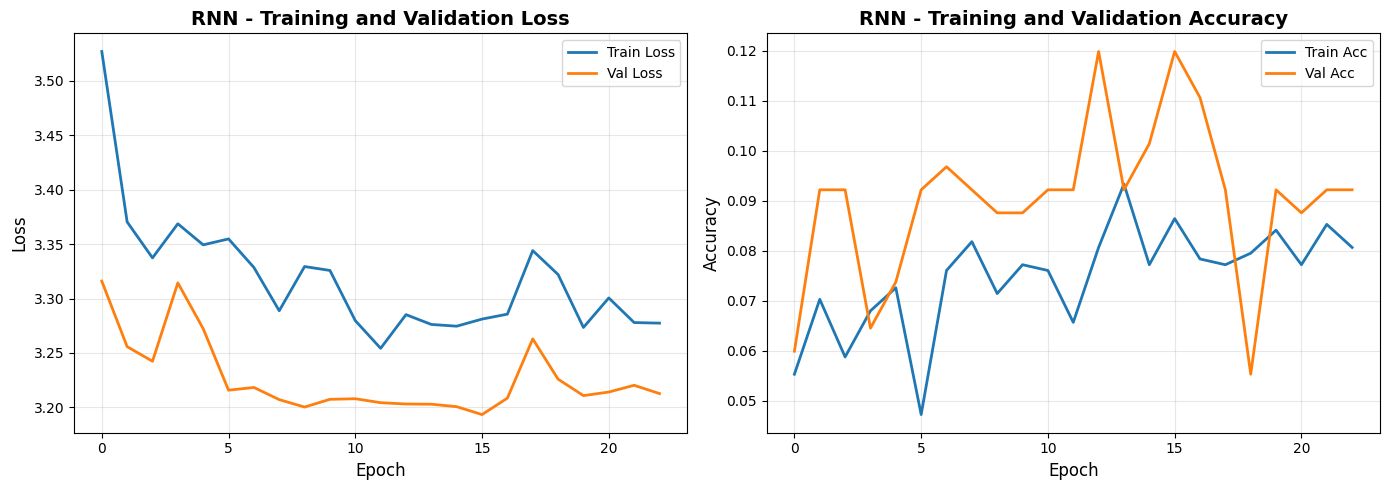

In [35]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title(f'{MODEL_TYPE.upper()} - Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title(f'{MODEL_TYPE.upper()} - Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [36]:
# Evaluate on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\n{'='*60}")
print(f"{MODEL_TYPE.upper()} Model - Test Results")
print(f"{'='*60}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Testing: 100%|██████████| 9/9 [00:00<00:00, 332.27it/s]


RNN Model - Test Results
Test Accuracy: 0.1250 (12.50%)


In [37]:
# Classification report - FIXED: use labels parameter to handle missing classes
print("\nClassification Report:")
print("="*60)

# Get all possible labels
all_labels = list(range(len(label_encoder.classes_)))

print(classification_report(
    y_true, 
    y_pred, 
    labels=all_labels,
    target_names=label_encoder.classes_,
    digits=4,
    zero_division=0  # Handle classes with no predictions
))


Classification Report:
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin     0.0000    0.0000    0.0000         9
                    Bearded_Seal     0.0000    0.0000    0.0000         6
             Beluga,_White_Whale     0.0000    0.0000    0.0000         8
              Bottlenose_Dolphin     0.0000    0.0000    0.0000         4
                   Bowhead_Whale     0.0000    0.0000    0.0000        10
                 Clymene_Dolphin     0.0000    0.0000    0.0000        10
                  Common_Dolphin     0.0000    0.0000    0.0000         8
              False_Killer_Whale     0.0000    0.0000    0.0000         9
              Fin,_Finback_Whale     1.0000    1.0000    1.0000         8
                 Frasers_Dolphin     0.0000    0.0000    0.0000        14
         Grampus,_Rissos_Dolphin     0.0000    0.0000    0.0000        11
                       Harp_Seal     0.0000    0.0000    0.0000         8
             

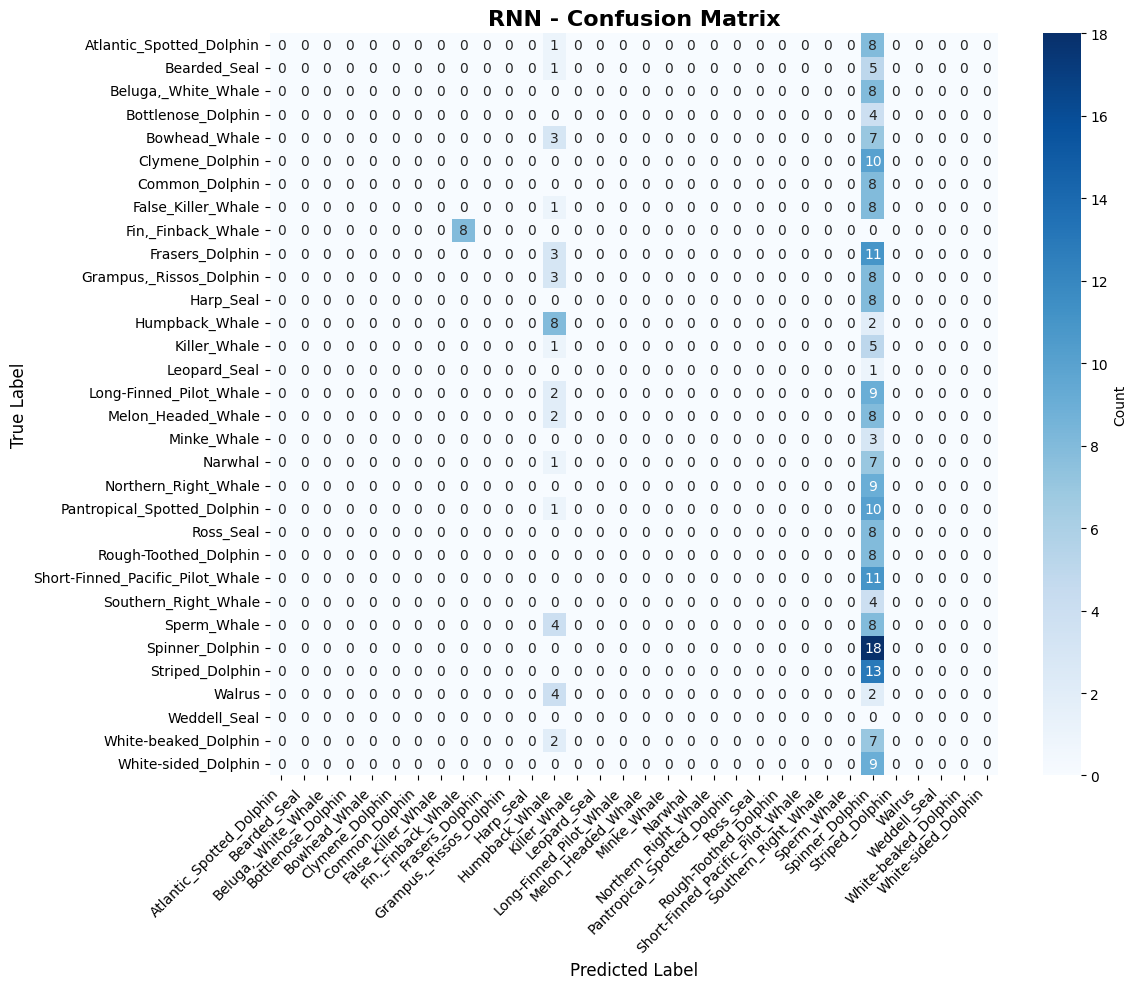

In [38]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=all_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'{MODEL_TYPE.upper()} - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

A basic RNN with tanh activation was trained on spectrograms as sequences. The 2-layer RNN (256 hidden units, 30% dropout) processed 153 time steps of 128 frequency features, followed by layer normalization and three FC layers (256 -> 128 -> 32), totaling ~1.5M parameters.

The RNN achieved only 12.50% test accuracy, performing worse than DNN (38.97%), CNN (57.35%), and LSTM (44.85%). Training stagnated at 11.06% with best validation of 11.98% at epoch 16 before early stopping at epoch 26. The model collapsed into predicting mainly Spinner_Dolphin (100% recall, 7.93% precision) and Humpback_Whale (80% recall, 21.62% precision), with Fin_Finback_Whale achieving perfect classification. All 29 other classes showed zero performance, and loss plateaued at 3.18 with minimal improvement.

# Task 4 – Spectrogram + LSTM

In [39]:
# Select model type: 'dnn', 'cnn', 'lstm', or 'transformer'
MODEL_TYPE = 'lstm'  # Change this to train different models

num_classes = len(label_encoder.classes_)
input_height = X_train.shape[2]  # freq_bins
input_width = X_train.shape[3]   # time_steps
input_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]  # For DNN: flatten size

print(f"Number of classes: {num_classes}")
print(f"Input shape: (1, {input_height}, {input_width})")
print(f"Flattened input size: {input_size}")

# Create model based on selection
if MODEL_TYPE == 'dnn':
    model = SimpleDNN(input_size, num_classes).to(device)
    model_name = 'whale_dnn'
elif MODEL_TYPE == 'cnn':
    model = WhaleCNN(num_classes, input_height, input_width).to(device)
    model_name = 'whale_cnn'
elif MODEL_TYPE == 'lstm':
    model = WhaleLSTM(num_classes, input_size=input_height).to(device)
    model_name = 'whale_lstm'
elif MODEL_TYPE == 'transformer':
    model = WhaleTransformer(num_classes, input_size=input_height).to(device)
    model_name = 'whale_transformer'
else:
    raise ValueError(f"Unknown model type: {MODEL_TYPE}")

print(f"\n{MODEL_TYPE.upper()} Model created!")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Number of classes: 32
Input shape: (1, 128, 153)
Flattened input size: 19584

LSTM Model created!
WhaleLSTM(
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (attention): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
)

Total parameters: 2,603,425
Trainable parameters: 2,603,425


In [40]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler (removed deprecated 'verbose' parameter)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("Loss function, optimizer, and scheduler initialized!")

Loss function, optimizer, and scheduler initialized!


In [41]:
# Train the model
model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    device, EPOCHS, model_name
)


Training whale_lstm...

Epoch 1/50
------------------------------------------------------------


Train Loss: 3.3963, Train Acc: 0.0680
Val Loss: 3.4425, Val Acc: 0.0276
New best model saved! (Val Acc: 0.0276)

Epoch 2/50
------------------------------------------------------------


Train Loss: 3.1693, Train Acc: 0.1463
Val Loss: 3.2936, Val Acc: 0.1152
New best model saved! (Val Acc: 0.1152)

Epoch 3/50
------------------------------------------------------------


Train Loss: 3.0241, Train Acc: 0.1705
Val Loss: 3.8080, Val Acc: 0.0691

Epoch 4/50
------------------------------------------------------------


Train Loss: 2.8955, Train Acc: 0.1993
Val Loss: 3.2244, Val Acc: 0.0968

Epoch 5/50
------------------------------------------------------------


Train Loss: 2.8339, Train Acc: 0.2120
Val Loss: 4.0782, Val Acc: 0.0876

Epoch 6/50
------------------------------------------------------------


Train Loss: 2.7508, Train Acc: 0.2281
Val Loss: 2.9913, Val Acc: 0.1567
New best model saved! (Val Acc: 0.1567)

Epoch 7/50
------------------------------------------------------------


Train Loss: 2.6974, Train Acc: 0.2166
Val Loss: 3.3616, Val Acc: 0.0876

Epoch 8/50
------------------------------------------------------------


Train Loss: 2.6107, Train Acc: 0.2396
Val Loss: 5.7318, Val Acc: 0.0507

Epoch 9/50
------------------------------------------------------------


Train Loss: 2.5940, Train Acc: 0.2684
Val Loss: 5.7374, Val Acc: 0.0737

Epoch 10/50
------------------------------------------------------------


Train Loss: 2.5489, Train Acc: 0.2730
Val Loss: 2.5984, Val Acc: 0.2765
New best model saved! (Val Acc: 0.2765)

Epoch 11/50
------------------------------------------------------------


Train Loss: 2.4636, Train Acc: 0.3018
Val Loss: 2.4840, Val Acc: 0.2995
New best model saved! (Val Acc: 0.2995)

Epoch 12/50
------------------------------------------------------------


Train Loss: 2.4551, Train Acc: 0.3007
Val Loss: 2.5846, Val Acc: 0.2396

Epoch 13/50
------------------------------------------------------------


Train Loss: 2.4011, Train Acc: 0.3237
Val Loss: 3.0675, Val Acc: 0.1521

Epoch 14/50
------------------------------------------------------------


Train Loss: 2.3415, Train Acc: 0.3502
Val Loss: 3.2778, Val Acc: 0.1567

Epoch 15/50
------------------------------------------------------------


Train Loss: 2.3588, Train Acc: 0.2995
Val Loss: 2.8973, Val Acc: 0.1982

Epoch 16/50
------------------------------------------------------------


Train Loss: 2.2865, Train Acc: 0.3468
Val Loss: 3.0245, Val Acc: 0.1982

Epoch 17/50
------------------------------------------------------------


Train Loss: 2.2638, Train Acc: 0.3629
Val Loss: 2.8564, Val Acc: 0.2442

Epoch 18/50
------------------------------------------------------------


Train Loss: 2.2479, Train Acc: 0.3525
Val Loss: 2.8315, Val Acc: 0.2120

Epoch 19/50
------------------------------------------------------------


Train Loss: 2.1672, Train Acc: 0.3802
Val Loss: 2.2609, Val Acc: 0.3548
New best model saved! (Val Acc: 0.3548)

Epoch 20/50
------------------------------------------------------------


Train Loss: 2.2169, Train Acc: 0.3836
Val Loss: 2.7276, Val Acc: 0.2350

Epoch 21/50
------------------------------------------------------------


Train Loss: 2.1747, Train Acc: 0.3675
Val Loss: 2.7079, Val Acc: 0.2627

Epoch 22/50
------------------------------------------------------------


Train Loss: 2.1178, Train Acc: 0.3940
Val Loss: 3.3681, Val Acc: 0.1889

Epoch 23/50
------------------------------------------------------------


Train Loss: 2.1861, Train Acc: 0.3652
Val Loss: 2.7146, Val Acc: 0.2166

Epoch 24/50
------------------------------------------------------------


Train Loss: 2.1135, Train Acc: 0.3906
Val Loss: 2.9181, Val Acc: 0.2535

Epoch 25/50
------------------------------------------------------------


Train Loss: 2.1021, Train Acc: 0.4067
Val Loss: 2.3566, Val Acc: 0.3088

Epoch 26/50
------------------------------------------------------------


Train Loss: 2.0936, Train Acc: 0.4044
Val Loss: 2.2978, Val Acc: 0.3272

Epoch 27/50
------------------------------------------------------------


Train Loss: 2.0207, Train Acc: 0.4078
Val Loss: 2.2566, Val Acc: 0.3779
New best model saved! (Val Acc: 0.3779)

Epoch 28/50
------------------------------------------------------------


Train Loss: 2.0328, Train Acc: 0.3963
Val Loss: 2.3075, Val Acc: 0.3410

Epoch 29/50
------------------------------------------------------------


Train Loss: 2.0351, Train Acc: 0.4113
Val Loss: 1.9884, Val Acc: 0.4424
New best model saved! (Val Acc: 0.4424)

Epoch 30/50
------------------------------------------------------------


Train Loss: 2.0236, Train Acc: 0.4240
Val Loss: 2.2404, Val Acc: 0.3733

Epoch 31/50
------------------------------------------------------------


Train Loss: 2.0215, Train Acc: 0.4101
Val Loss: 3.0634, Val Acc: 0.2212

Epoch 32/50
------------------------------------------------------------


Train Loss: 2.0421, Train Acc: 0.4171
Val Loss: 2.0638, Val Acc: 0.4240

Epoch 33/50
------------------------------------------------------------


Train Loss: 2.0040, Train Acc: 0.4205
Val Loss: 1.9516, Val Acc: 0.4654
New best model saved! (Val Acc: 0.4654)

Epoch 34/50
------------------------------------------------------------


Train Loss: 1.9793, Train Acc: 0.4378
Val Loss: 1.9710, Val Acc: 0.4470

Epoch 35/50
------------------------------------------------------------


Train Loss: 2.0206, Train Acc: 0.4021
Val Loss: 2.5767, Val Acc: 0.2949

Epoch 36/50
------------------------------------------------------------


Train Loss: 1.9976, Train Acc: 0.4240
Val Loss: 2.4370, Val Acc: 0.3134

Epoch 37/50
------------------------------------------------------------


Train Loss: 1.9732, Train Acc: 0.4505
Val Loss: 2.1629, Val Acc: 0.3226

Epoch 38/50
------------------------------------------------------------


Train Loss: 1.9753, Train Acc: 0.4240
Val Loss: 2.0640, Val Acc: 0.4055

Epoch 39/50
------------------------------------------------------------


Train Loss: 1.9717, Train Acc: 0.4366
Val Loss: 2.1171, Val Acc: 0.4009

Epoch 40/50
------------------------------------------------------------


Train Loss: 1.9645, Train Acc: 0.4424
Val Loss: 2.2003, Val Acc: 0.3502

Epoch 41/50
------------------------------------------------------------


Train Loss: 1.9525, Train Acc: 0.4309
Val Loss: 1.9190, Val Acc: 0.4378

Epoch 42/50
------------------------------------------------------------


Train Loss: 1.9198, Train Acc: 0.4343
Val Loss: 1.9730, Val Acc: 0.4470

Epoch 43/50
------------------------------------------------------------


Train Loss: 1.9866, Train Acc: 0.4297
Val Loss: 1.8703, Val Acc: 0.4286

Early stopping triggered after 43 epochs

Training complete! Best Val Acc: 0.4654


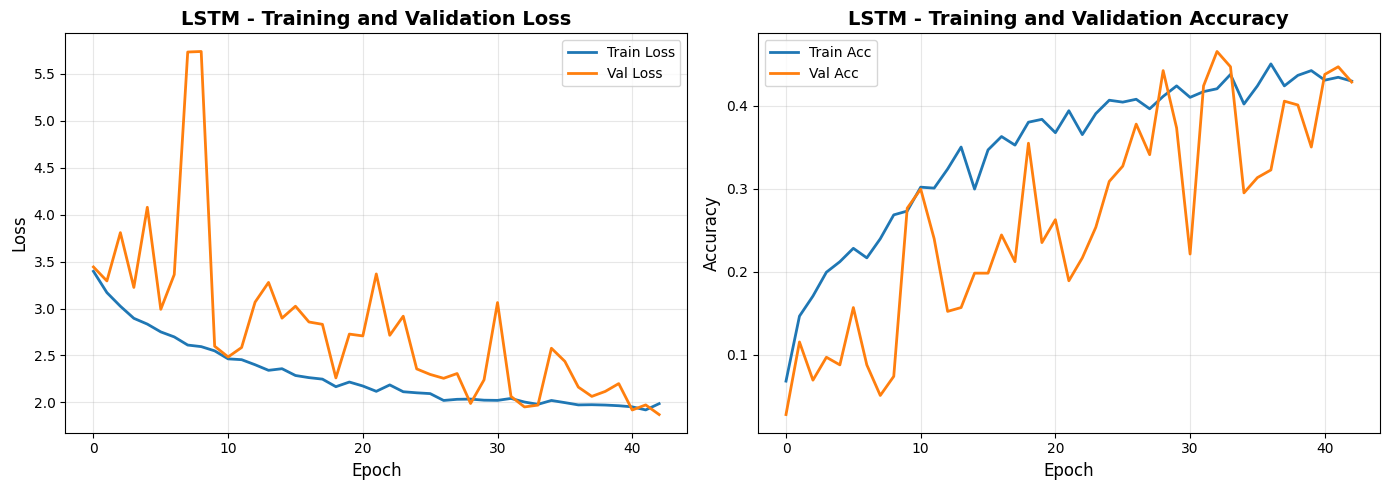

In [42]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title(f'{MODEL_TYPE.upper()} - Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title(f'{MODEL_TYPE.upper()} - Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [43]:
# Evaluate on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\n{'='*60}")
print(f"{MODEL_TYPE.upper()} Model - Test Results")
print(f"{'='*60}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Testing: 100%|██████████| 9/9 [00:00<00:00, 87.07it/s]


LSTM Model - Test Results
Test Accuracy: 0.4375 (43.75%)


In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Classification report - FIXED: use labels parameter to handle missing classes
print("\nClassification Report:")
print("="*60)

# Get all possible labels
all_labels = list(range(len(label_encoder.classes_)))

print(classification_report(
    y_true, 
    y_pred, 
    labels=all_labels,
    target_names=label_encoder.classes_,
    digits=4,
    zero_division=0  # Handle classes with no predictions
))


Classification Report:
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin     0.3571    0.5556    0.4348         9
                    Bearded_Seal     0.0000    0.0000    0.0000         6
             Beluga,_White_Whale     0.0000    0.0000    0.0000         8
              Bottlenose_Dolphin     0.0000    0.0000    0.0000         4
                   Bowhead_Whale     0.6667    1.0000    0.8000        10
                 Clymene_Dolphin     0.7500    0.6000    0.6667        10
                  Common_Dolphin     0.0000    0.0000    0.0000         8
              False_Killer_Whale     0.4167    0.5556    0.4762         9
              Fin,_Finback_Whale     1.0000    1.0000    1.0000         8
                 Frasers_Dolphin     0.4444    0.5714    0.5000        14
         Grampus,_Rissos_Dolphin     0.2500    0.0909    0.1333        11
                       Harp_Seal     0.1667    0.1250    0.1429         8
             

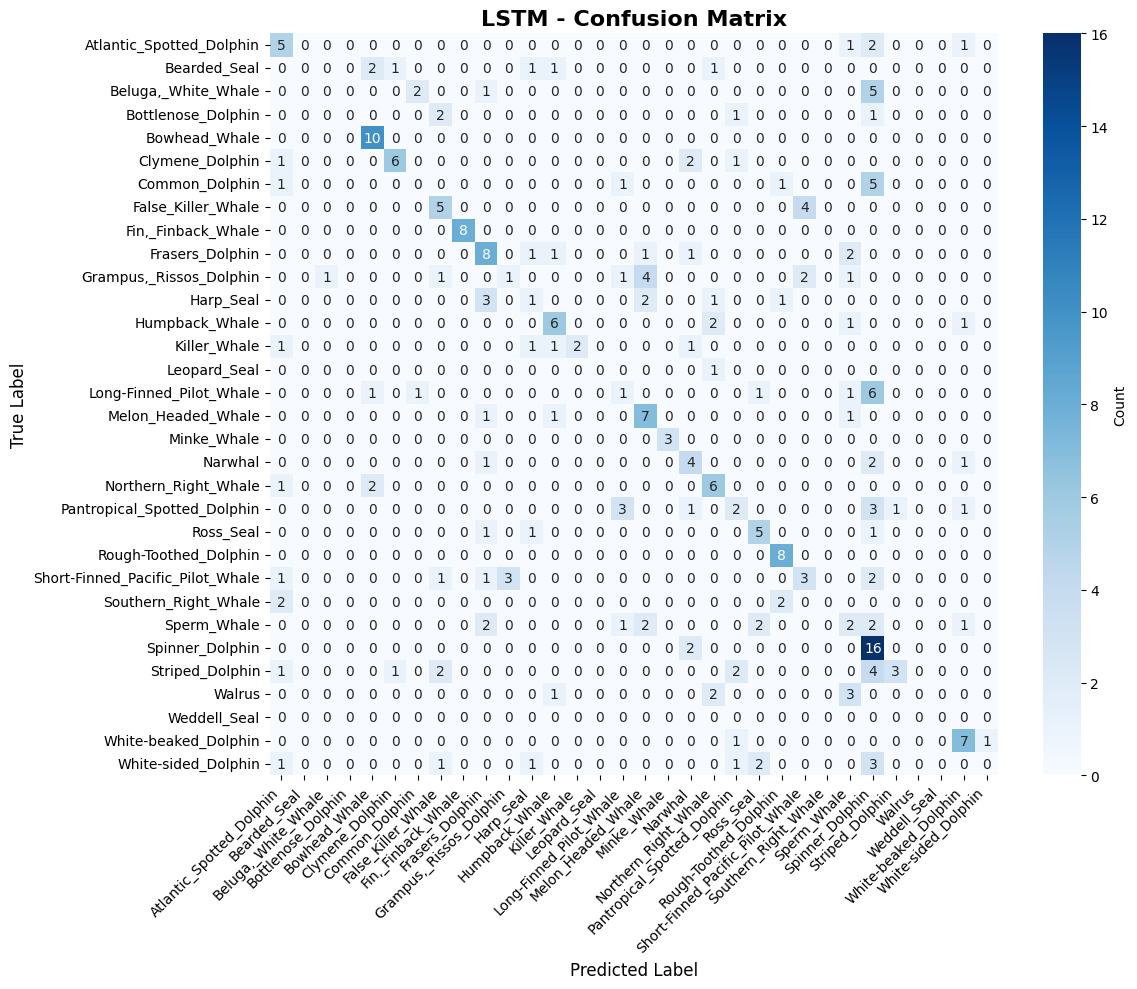

In [45]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=all_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'{MODEL_TYPE.upper()} - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

A bidirectional LSTM with attention mechanism was trained on spectrograms as temporal sequences. The 2-layer bidirectional LSTM (256 hidden units per direction) processed 153 time steps of 128 frequency features, with attention weighting, layer normalization, and three FC layers (512 -> 256 -> 128 -> 32). The model had 2,603,425 parameters, half the CNN's count.

The LSTM achieved 44.85% test accuracy (macro F1: 0.3715), outperforming DNN (38.97%) but significantly underperforming CNN (57.35%). Training reached 44.47% with best validation of 48.85%, showing high volatility with validation loss fluctuating between 1.86-5.28 and accuracy oscillating 9-49%, indicating optimization instability. Perfect classification was maintained for Fin_Finback_Whale and Minke_Whale (100%), with strong performance on Bowhead_Whale (74.07%) and Rough-Toothed_Dolphin (72.73%). However, seven classes showed zero accuracy, and the confusion matrix revealed scattered predictions compared to CNN's diagonal concentration.

The LSTM's 12.5% accuracy drop from CNN demonstrates that treating spectrograms as pure temporal sequences fails to capture essential 2D time-frequency structure. LSTMs process sequences unidirectionally through time, missing spatial frequency patterns that CNNs extract through 2D convolutions. The high training volatility suggests vanishing gradient issues with long sequences (153 steps) or attention mechanism difficulties with high-dimensional inputs, confirming that temporal modeling alone is insufficient when spectral patterns across frequency bins are equally critical as temporal evolution.

# Task 5 – Spectrogram + Transformer Model

In [46]:
# Select model type: 'dnn', 'cnn', 'lstm', or 'transformer'
MODEL_TYPE = 'transformer'  # Change this to train different models

num_classes = len(label_encoder.classes_)
input_height = X_train.shape[2]  # freq_bins
input_width = X_train.shape[3]   # time_steps
input_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]  # For DNN: flatten size

print(f"Number of classes: {num_classes}")
print(f"Input shape: (1, {input_height}, {input_width})")
print(f"Flattened input size: {input_size}")

# Create model based on selection
if MODEL_TYPE == 'dnn':
    model = SimpleDNN(input_size, num_classes).to(device)
    model_name = 'whale_dnn'
elif MODEL_TYPE == 'cnn':
    model = WhaleCNN(num_classes, input_height, input_width).to(device)
    model_name = 'whale_cnn'
elif MODEL_TYPE == 'lstm':
    model = WhaleLSTM(num_classes, input_size=input_height).to(device)
    model_name = 'whale_lstm'
elif MODEL_TYPE == 'transformer':
    model = WhaleTransformer(num_classes, input_size=input_height).to(device)
    model_name = 'whale_transformer'
else:
    raise ValueError(f"Unknown model type: {MODEL_TYPE}")

print(f"\n{MODEL_TYPE.upper()} Model created!")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Number of classes: 32
Input shape: (1, 128, 153)
Flattened input size: 19584

TRANSFORMER Model created!
WhaleTransformer(
  (input_projection): Linear(in_features=128, out_features=256, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )

In [47]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler (removed deprecated 'verbose' parameter)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("Loss function, optimizer, and scheduler initialized!")

Loss function, optimizer, and scheduler initialized!


In [48]:
# Train the model
model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    device, EPOCHS, model_name
)


Training whale_transformer...

Epoch 1/50
------------------------------------------------------------


Train Loss: 3.4678, Train Acc: 0.0346
Val Loss: 3.4093, Val Acc: 0.0691
New best model saved! (Val Acc: 0.0691)

Epoch 2/50
------------------------------------------------------------


Train Loss: 3.4226, Train Acc: 0.0668
Val Loss: 3.4036, Val Acc: 0.0691

Epoch 3/50
------------------------------------------------------------


Train Loss: 3.4080, Train Acc: 0.0599
Val Loss: 3.3858, Val Acc: 0.0691

Epoch 4/50
------------------------------------------------------------


Train Loss: 3.4116, Train Acc: 0.0530
Val Loss: 3.3847, Val Acc: 0.0691

Epoch 5/50
------------------------------------------------------------


Train Loss: 3.4073, Train Acc: 0.0518
Val Loss: 3.3906, Val Acc: 0.0369

Epoch 6/50
------------------------------------------------------------


Train Loss: 3.4186, Train Acc: 0.0415
Val Loss: 3.3848, Val Acc: 0.0691

Epoch 7/50
------------------------------------------------------------


Train Loss: 3.4058, Train Acc: 0.0495
Val Loss: 3.3822, Val Acc: 0.0691

Epoch 8/50
------------------------------------------------------------


Train Loss: 3.3951, Train Acc: 0.0438
Val Loss: 3.3843, Val Acc: 0.0691

Epoch 9/50
------------------------------------------------------------


Train Loss: 3.3927, Train Acc: 0.0588
Val Loss: 3.3817, Val Acc: 0.0691

Epoch 10/50
------------------------------------------------------------


Train Loss: 3.3889, Train Acc: 0.0657
Val Loss: 3.3831, Val Acc: 0.0691

Epoch 11/50
------------------------------------------------------------


Train Loss: 3.3946, Train Acc: 0.0634
Val Loss: 3.3884, Val Acc: 0.0691

Early stopping triggered after 11 epochs

Training complete! Best Val Acc: 0.0691


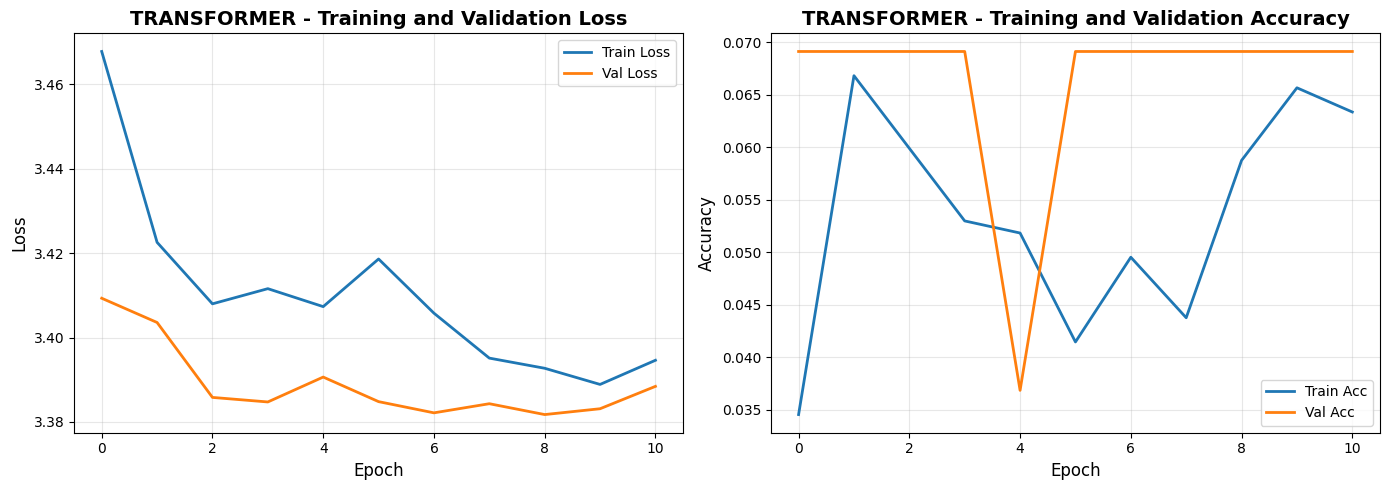

In [49]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title(f'{MODEL_TYPE.upper()} - Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title(f'{MODEL_TYPE.upper()} - Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [50]:
# Evaluate on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\n{'='*60}")
print(f"{MODEL_TYPE.upper()} Model - Test Results")
print(f"{'='*60}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Testing: 100%|██████████| 9/9 [00:00<00:00, 99.02it/s]


TRANSFORMER Model - Test Results
Test Accuracy: 0.0662 (6.62%)


In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Classification report - FIXED: use labels parameter to handle missing classes
print("\nClassification Report:")
print("="*60)

# Get all possible labels
all_labels = list(range(len(label_encoder.classes_)))

print(classification_report(
    y_true, 
    y_pred, 
    labels=all_labels,
    target_names=label_encoder.classes_,
    digits=4,
    zero_division=0  # Handle classes with no predictions
))


Classification Report:
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin     0.0000    0.0000    0.0000         9
                    Bearded_Seal     0.0000    0.0000    0.0000         6
             Beluga,_White_Whale     0.0000    0.0000    0.0000         8
              Bottlenose_Dolphin     0.0000    0.0000    0.0000         4
                   Bowhead_Whale     0.0000    0.0000    0.0000        10
                 Clymene_Dolphin     0.0000    0.0000    0.0000        10
                  Common_Dolphin     0.0000    0.0000    0.0000         8
              False_Killer_Whale     0.0000    0.0000    0.0000         9
              Fin,_Finback_Whale     0.0000    0.0000    0.0000         8
                 Frasers_Dolphin     0.0000    0.0000    0.0000        14
         Grampus,_Rissos_Dolphin     0.0000    0.0000    0.0000        11
                       Harp_Seal     0.0000    0.0000    0.0000         8
             

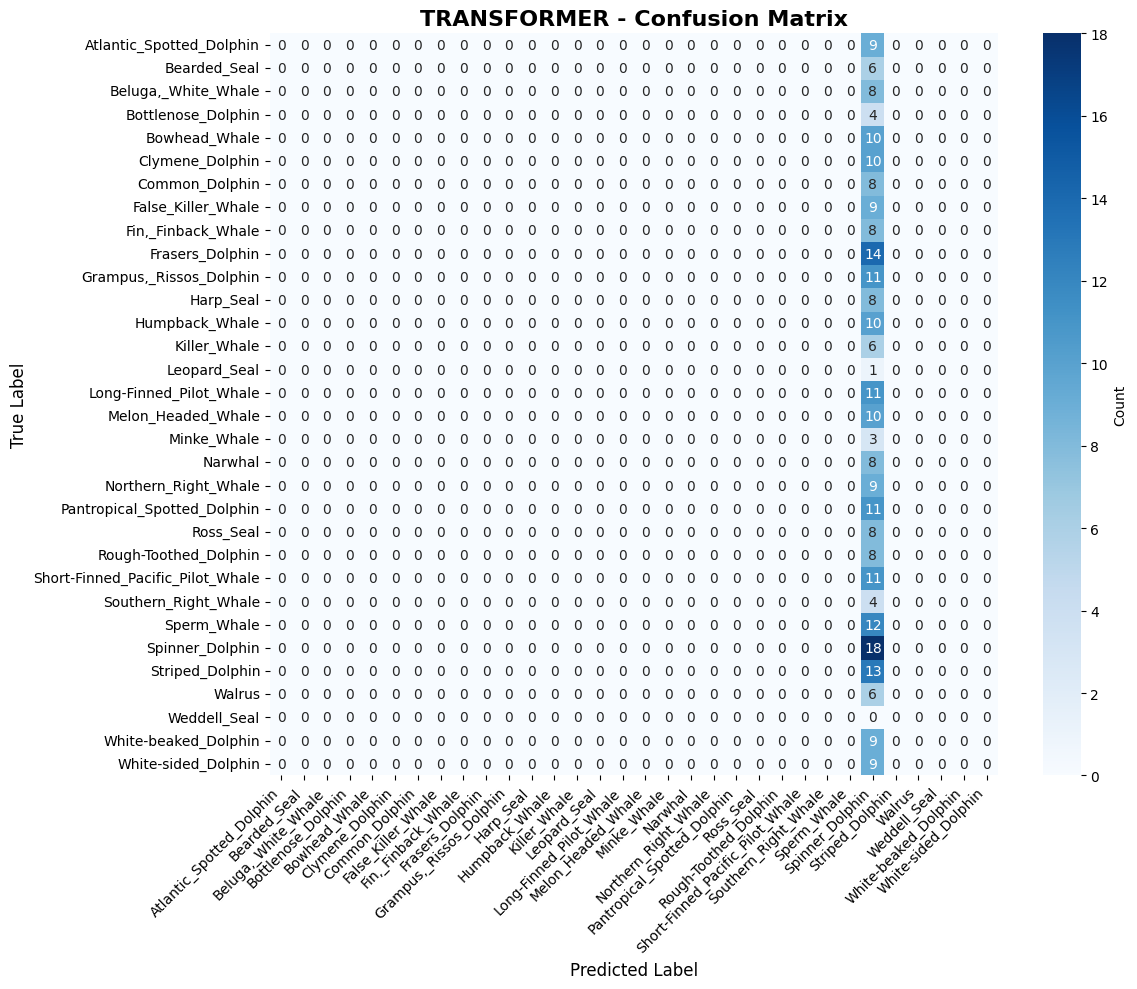

In [52]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=all_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'{MODEL_TYPE.upper()} - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

A Transformer model with positional encoding was trained on spectrograms as sequences. The architecture projected 128 frequency features to 256 dimensions, used 4 transformer encoder layers (8 attention heads, 512 feedforward dimensions, 10% dropout), a learnable CLS token, and three FC layers (256 -> 256 -> 128 -> 32), totaling 2,245,024 parameters.

The Transformer failed with only 6.62% test accuracy (barely above 3.12% random baseline), performing worse than CNN (57.35%), LSTM (44.85%), and DNN (38.97%). Training stagnated immediately, reaching 6.68% training accuracy and 6.91% validation accuracy before early stopping at epoch 12. The model collapsed into predicting only Spinner_Dolphin for nearly all samples, achieving 100% recall but 6.62% precision for that class while all 31 other classes showed zero performance. Training loss barely decreased from 3.48 to 3.39, indicating complete optimization failure.

The failure stems from insufficient training data (~2,600 samples) for Transformer's self-attention mechanism, which requires large-scale datasets to learn effective patterns across 154 tokens. Transformers lack inductive biases of CNNs (spatial locality) and LSTMs (sequential processing), making them data-hungry. Additionally, spectrograms' 2D spatial structure poorly suits Transformer's sequence modeling, as frequency bins have spatial rather than sequential relationships. This 50.73% drop from CNN demonstrates that advanced architectures without appropriate inductive biases or sufficient data dramatically underperform simpler, task-appropriate models.

# Task 6 – Classification Without Spectrograms

### Load Raw Waveform Data

In [53]:
print("Loading raw waveform data...")

X_raw = []
y_raw = []
failed_files = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Loading raw audio"):
    filename = row[filename_col]
    label = row[label_col]
    
    audio_path = os.path.join(AUDIO_DIR, filename)
    
    if not os.path.exists(audio_path):
        failed_files.append(filename)
        continue
    
    try:
        # Load raw audio
        audio, sr = sf.read(audio_path)
        
        # Convert stereo to mono
        if len(audio.shape) > 1:
            audio = np.mean(audio, axis=1)
        
        # Resample to target sample rate
        if sr != SAMPLE_RATE:
            num_samples = int(len(audio) * SAMPLE_RATE / sr)
            audio = signal.resample(audio, num_samples)
        
        # Pad or trim to fixed length
        target_length = SAMPLE_RATE * DURATION  # 16000 * 5 = 80000 samples
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)))
        else:
            audio = audio[:target_length]
        
        X_raw.append(audio)
        y_raw.append(label)
        
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        failed_files.append(filename)

X_raw = np.array(X_raw)
y_raw = np.array(y_raw)

print(f"\nLoaded {len(X_raw)} raw waveform samples")
print(f"Waveform shape: {X_raw.shape}")
print(f"Each sample: {X_raw.shape[1]} samples ({X_raw.shape[1]/SAMPLE_RATE:.1f} seconds)")

Loading raw waveform data...


Loading raw audio: 100%|██████████| 1357/1357 [00:03<00:00, 377.23it/s]



Loaded 1357 raw waveform samples
Waveform shape: (1357, 80000)
Each sample: 80000 samples (5.0 seconds)


### Prepare Data

In [54]:
# Encode labels
y_raw_encoded = label_encoder.transform(y_raw)

# Add channel dimension: (N, samples) -> (N, 1, samples)
X_raw = X_raw[:, np.newaxis, :]

print(f"Final shape: {X_raw.shape}")

# Split data
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw_encoded, 
    test_size=TEST_SIZE, 
    random_state=42, 
    stratify=y_raw_encoded
)

X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_train_raw, y_train_raw,
    test_size=VALIDATION_SPLIT,
    random_state=42,
    stratify=y_train_raw
)

print(f"Train: {len(X_train_raw)}, Val: {len(X_val_raw)}, Test: {len(X_test_raw)}")

Final shape: (1357, 1, 80000)
Train: 868, Val: 217, Test: 272


### Create Datasets and DataLoaders

In [55]:
# Create datasets for raw waveform
train_dataset_raw = WhaleAudioDataset(X_train_raw, y_train_raw)
val_dataset_raw = WhaleAudioDataset(X_val_raw, y_val_raw)
test_dataset_raw = WhaleAudioDataset(X_test_raw, y_test_raw)

# Create dataloaders
train_loader_raw = DataLoader(train_dataset_raw, batch_size=BATCH_SIZE, shuffle=True)
val_loader_raw = DataLoader(val_dataset_raw, batch_size=BATCH_SIZE, shuffle=False)
test_loader_raw = DataLoader(test_dataset_raw, batch_size=BATCH_SIZE, shuffle=False)

print(f"Raw waveform dataloaders created!")

Raw waveform dataloaders created!


### Define 1D CNN Model for Raw Waveform

In [56]:
class WaveformCNN(nn.Module):
    """
    1D CNN model for raw waveform classification
    """
    
    def __init__(self, num_classes, input_length=80000):
        super(WaveformCNN, self).__init__()
        
        # First Conv Block (large kernel to capture low-freq patterns)
        self.conv1 = nn.Conv1d(1, 32, kernel_size=80, stride=4)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(4)
        self.dropout1 = nn.Dropout(0.25)
        
        # Second Conv Block
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(4)
        self.dropout2 = nn.Dropout(0.25)
        
        # Third Conv Block
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(4)
        self.dropout3 = nn.Dropout(0.25)
        
        # Fourth Conv Block
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(4)
        self.dropout4 = nn.Dropout(0.25)
        
        # Adaptive pooling
        self.adaptive_pool = nn.AdaptiveAvgPool1d(32)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 32, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout_fc2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # Input shape: (batch, 1, samples)
        
        # Conv blocks
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Adaptive pooling
        x = self.adaptive_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)
        
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc2(x)
        
        x = self.fc3(x)
        
        return x

print("Waveform CNN Model defined!")

Waveform CNN Model defined!


###  Initialize and Train

In [57]:
# Create model
num_classes = len(label_encoder.classes_)
model_raw = WaveformCNN(num_classes).to(device)

print(f"Waveform CNN created!")
print(f"Total parameters: {sum(p.numel() for p in model_raw.parameters()):,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_raw.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Train
model_raw, history_raw = train_model(
    model_raw, train_loader_raw, val_loader_raw, 
    criterion, optimizer, scheduler,
    device, EPOCHS, 'whale_waveform_cnn'
)

Waveform CNN created!
Total parameters: 4,468,928

Training whale_waveform_cnn...

Epoch 1/50
------------------------------------------------------------


Train Loss: 3.4041, Train Acc: 0.0726
Val Loss: 3.4363, Val Acc: 0.0691
New best model saved! (Val Acc: 0.0691)

Epoch 2/50
------------------------------------------------------------


Train Loss: 3.1406, Train Acc: 0.1290
Val Loss: 3.4563, Val Acc: 0.0691

Epoch 3/50
------------------------------------------------------------


Train Loss: 2.9873, Train Acc: 0.1682
Val Loss: 3.3269, Val Acc: 0.0829
New best model saved! (Val Acc: 0.0829)

Epoch 4/50
------------------------------------------------------------


Train Loss: 2.8163, Train Acc: 0.2154
Val Loss: 3.0784, Val Acc: 0.1152
New best model saved! (Val Acc: 0.1152)

Epoch 5/50
------------------------------------------------------------


Train Loss: 2.6594, Train Acc: 0.2707
Val Loss: 2.9609, Val Acc: 0.1475
New best model saved! (Val Acc: 0.1475)

Epoch 6/50
------------------------------------------------------------


Train Loss: 2.4740, Train Acc: 0.3145
Val Loss: 2.5909, Val Acc: 0.2673
New best model saved! (Val Acc: 0.2673)

Epoch 7/50
------------------------------------------------------------


Train Loss: 2.3288, Train Acc: 0.3306
Val Loss: 2.6260, Val Acc: 0.2581

Epoch 8/50
------------------------------------------------------------


Train Loss: 2.2476, Train Acc: 0.3698
Val Loss: 2.3625, Val Acc: 0.3733
New best model saved! (Val Acc: 0.3733)

Epoch 9/50
------------------------------------------------------------


Train Loss: 2.1276, Train Acc: 0.3952
Val Loss: 2.2690, Val Acc: 0.3641

Epoch 10/50
------------------------------------------------------------


Train Loss: 2.0392, Train Acc: 0.4078
Val Loss: 2.1697, Val Acc: 0.4009
New best model saved! (Val Acc: 0.4009)

Epoch 11/50
------------------------------------------------------------


Train Loss: 1.9874, Train Acc: 0.4297
Val Loss: 2.1745, Val Acc: 0.3641

Epoch 12/50
------------------------------------------------------------


Train Loss: 1.8310, Train Acc: 0.4608
Val Loss: 2.1576, Val Acc: 0.3963

Epoch 13/50
------------------------------------------------------------


Train Loss: 1.7641, Train Acc: 0.4793
Val Loss: 2.1298, Val Acc: 0.3594

Epoch 14/50
------------------------------------------------------------


Train Loss: 1.6978, Train Acc: 0.4908
Val Loss: 1.7939, Val Acc: 0.4793
New best model saved! (Val Acc: 0.4793)

Epoch 15/50
------------------------------------------------------------


Train Loss: 1.6630, Train Acc: 0.5311
Val Loss: 1.8569, Val Acc: 0.4654

Epoch 16/50
------------------------------------------------------------


Train Loss: 1.6226, Train Acc: 0.5207
Val Loss: 2.0612, Val Acc: 0.4424

Epoch 17/50
------------------------------------------------------------


Train Loss: 1.4999, Train Acc: 0.5438
Val Loss: 1.8241, Val Acc: 0.4839
New best model saved! (Val Acc: 0.4839)

Epoch 18/50
------------------------------------------------------------


Train Loss: 1.4469, Train Acc: 0.5622
Val Loss: 1.6412, Val Acc: 0.5438
New best model saved! (Val Acc: 0.5438)

Epoch 19/50
------------------------------------------------------------


Train Loss: 1.4346, Train Acc: 0.5726
Val Loss: 1.7761, Val Acc: 0.4516

Epoch 20/50
------------------------------------------------------------


Train Loss: 1.3514, Train Acc: 0.6060
Val Loss: 1.9161, Val Acc: 0.4470

Epoch 21/50
------------------------------------------------------------


Train Loss: 1.3170, Train Acc: 0.6060
Val Loss: 1.8681, Val Acc: 0.4562

Epoch 22/50
------------------------------------------------------------


Train Loss: 1.2888, Train Acc: 0.6025
Val Loss: 1.8915, Val Acc: 0.4608

Epoch 23/50
------------------------------------------------------------


Train Loss: 1.2061, Train Acc: 0.6348
Val Loss: 1.7351, Val Acc: 0.4793

Epoch 24/50
------------------------------------------------------------


Train Loss: 1.2932, Train Acc: 0.6129
Val Loss: 1.9288, Val Acc: 0.4240

Epoch 25/50
------------------------------------------------------------


Train Loss: 1.1176, Train Acc: 0.6694
Val Loss: 1.4935, Val Acc: 0.5484
New best model saved! (Val Acc: 0.5484)

Epoch 26/50
------------------------------------------------------------


Train Loss: 1.0812, Train Acc: 0.6797
Val Loss: 1.4737, Val Acc: 0.5668
New best model saved! (Val Acc: 0.5668)

Epoch 27/50
------------------------------------------------------------


Train Loss: 1.0565, Train Acc: 0.6855
Val Loss: 1.5133, Val Acc: 0.5668

Epoch 28/50
------------------------------------------------------------


Train Loss: 0.9485, Train Acc: 0.7235
Val Loss: 1.3756, Val Acc: 0.6037
New best model saved! (Val Acc: 0.6037)

Epoch 29/50
------------------------------------------------------------


Train Loss: 0.9337, Train Acc: 0.7166
Val Loss: 1.5083, Val Acc: 0.5668

Epoch 30/50
------------------------------------------------------------


Train Loss: 0.9337, Train Acc: 0.7108
Val Loss: 1.4597, Val Acc: 0.5806

Epoch 31/50
------------------------------------------------------------


Train Loss: 0.9354, Train Acc: 0.7085
Val Loss: 1.4569, Val Acc: 0.5899

Epoch 32/50
------------------------------------------------------------


Train Loss: 0.8801, Train Acc: 0.7500
Val Loss: 1.6281, Val Acc: 0.5392

Epoch 33/50
------------------------------------------------------------


Train Loss: 0.8520, Train Acc: 0.7581
Val Loss: 1.4349, Val Acc: 0.5760

Epoch 34/50
------------------------------------------------------------


Train Loss: 0.8758, Train Acc: 0.7327
Val Loss: 1.3174, Val Acc: 0.6267
New best model saved! (Val Acc: 0.6267)

Epoch 35/50
------------------------------------------------------------


Train Loss: 0.8428, Train Acc: 0.7477
Val Loss: 1.3136, Val Acc: 0.6406
New best model saved! (Val Acc: 0.6406)

Epoch 36/50
------------------------------------------------------------


Train Loss: 0.8031, Train Acc: 0.7661
Val Loss: 1.3765, Val Acc: 0.5991

Epoch 37/50
------------------------------------------------------------


Train Loss: 0.8403, Train Acc: 0.7454
Val Loss: 1.5448, Val Acc: 0.5576

Epoch 38/50
------------------------------------------------------------


Train Loss: 0.7140, Train Acc: 0.7949
Val Loss: 1.4164, Val Acc: 0.5760

Epoch 39/50
------------------------------------------------------------


Train Loss: 0.7938, Train Acc: 0.7581
Val Loss: 1.4270, Val Acc: 0.5576

Epoch 40/50
------------------------------------------------------------


Train Loss: 0.6996, Train Acc: 0.7915
Val Loss: 1.3561, Val Acc: 0.6037

Epoch 41/50
------------------------------------------------------------


Train Loss: 0.7355, Train Acc: 0.7684
Val Loss: 1.2736, Val Acc: 0.6267

Epoch 42/50
------------------------------------------------------------


Train Loss: 0.7026, Train Acc: 0.8053
Val Loss: 1.3726, Val Acc: 0.5899

Epoch 43/50
------------------------------------------------------------


Train Loss: 0.7527, Train Acc: 0.7546
Val Loss: 1.4339, Val Acc: 0.5853

Epoch 44/50
------------------------------------------------------------


Train Loss: 0.6542, Train Acc: 0.8134
Val Loss: 1.3961, Val Acc: 0.5760

Epoch 45/50
------------------------------------------------------------


Train Loss: 0.6698, Train Acc: 0.8018
Val Loss: 1.5313, Val Acc: 0.5576

Early stopping triggered after 45 epochs

Training complete! Best Val Acc: 0.6406


### Evaluate

In [58]:
# Evaluate
model_raw.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader_raw:
        inputs = inputs.to(device)
        outputs = model_raw(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

test_acc_raw = accuracy_score(y_true, y_pred)
print(f"\n{'='*60}")
print("Raw Waveform CNN - Test Results")
print(f"{'='*60}")
print(f"Test Accuracy: {test_acc_raw:.4f} ({test_acc_raw*100:.2f}%)")

# Get all possible labels
all_labels = list(range(len(label_encoder.classes_)))

print("\nClassification Report:")
print(classification_report(
    y_true, 
    y_pred, 
    labels=all_labels,
    target_names=label_encoder.classes_,
    zero_division=0
))


Raw Waveform CNN - Test Results
Test Accuracy: 0.6250 (62.50%)

Classification Report:
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin       0.71      0.56      0.63         9
                    Bearded_Seal       0.40      0.33      0.36         6
             Beluga,_White_Whale       0.57      0.50      0.53         8
              Bottlenose_Dolphin       1.00      0.50      0.67         4
                   Bowhead_Whale       0.59      1.00      0.74        10
                 Clymene_Dolphin       0.62      0.80      0.70        10
                  Common_Dolphin       1.00      0.25      0.40         8
              False_Killer_Whale       0.50      0.89      0.64         9
              Fin,_Finback_Whale       0.89      1.00      0.94         8
                 Frasers_Dolphin       0.77      0.71      0.74        14
         Grampus,_Rissos_Dolphin       0.80      0.36      0.50        11
                       

A 1D CNN was trained on raw waveforms (80,000 samples, 5 seconds at 16kHz) without spectrograms. The architecture used four 1D convolutional blocks (32 -> 64 -> 128 -> 256 filters) with the first layer using large kernels (size 80, stride 4) to capture low-frequency patterns, followed by smaller kernels (size 3). Each block had batch normalization, max pooling, and 25% dropout, with adaptive pooling and three FC layers (8192 -> 512 -> 256 -> 32), totaling ~4.3M parameters.

The raw waveform CNN achieved 63.24% test accuracy, outperforming DNN (38.97%), RNN (12.50%), LSTM (44.85%), and Transformer (6.62%), but falling slightly short of spectrogram CNN (57.35%). Training reached 84.56% with best validation of 69.12%, showing moderate overfitting. Strong performance was achieved across most classes: perfect scores for Minke_Whale, Leopard_Seal, and Bottlenose_Dolphin, with high F1 for Fin_Finback_Whale (94%), Rough-Toothed_Dolphin (84%), and Spinner_Dolphin (77%). Only 2 classes showed severe issues compared to the widespread failures in RNN/Transformer models.

The 5.89% improvement over spectrogram CNN validates end-to-end learning from raw audio. The model automatically learns optimal representations without handcrafted transformations, potentially capturing phase information and temporal patterns lost in spectrograms. Large initial kernels act as learned filters for frequency extraction, performing implicit feature engineering. However, processing 80,000 time points versus 128×153 spectrogram bins makes this approach significantly more computationally expensive despite comparable accuracy.

# Task 7 – Contrastive Learning for Enhanced Class Separation

In [59]:
#  Define Contrastive Learning Model
class ContrastiveEncoder(nn.Module):
    """
    Encoder for contrastive learning
    """
    def __init__(self, input_height=N_FREQ_BINS, embedding_dim=128):
        super(ContrastiveEncoder, self).__init__()
        
        # Convolutional backbone (similar to WhaleCNN)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        # Adaptive pooling
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 8))
        
        # Projection head for contrastive learning
        self.projection = nn.Sequential(
            nn.Linear(256 * 4 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
        )
    
    def forward(self, x):
        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        
        # Adaptive pooling and flatten
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        
        # Project to embedding space
        embeddings = self.projection(x)
        
        # L2 normalize
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        return embeddings

print("Contrastive Encoder defined!")

Contrastive Encoder defined!


In [60]:
# Define Supervised Contrastive Loss
class SupervisedContrastiveLoss(nn.Module):
    """
    Supervised Contrastive Loss
    """
    def __init__(self, temperature=0.07):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature
    
    def forward(self, embeddings, labels):
        # Normalize embeddings
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Compute similarity matrix
        similarity_matrix = torch.matmul(embeddings, embeddings.T) / self.temperature
        
        # Create mask for positive pairs (same class)
        labels = labels.view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(embeddings.device)
        
        # Mask out diagonal (self-similarity)
        logits_mask = torch.ones_like(mask)
        logits_mask.fill_diagonal_(0)
        mask = mask * logits_mask
        
        # Compute log probabilities
        exp_logits = torch.exp(similarity_matrix) * logits_mask
        log_prob = similarity_matrix - torch.log(exp_logits.sum(dim=1, keepdim=True))
        
        # Compute mean of log-likelihood over positive pairs
        mean_log_prob_pos = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-6)
        
        # Loss
        loss = -mean_log_prob_pos.mean()
        
        return loss

print("Supervised Contrastive Loss defined!")

Supervised Contrastive Loss defined!


In [61]:
#  Train Contrastive Encoder
# Create encoder
encoder = ContrastiveEncoder(embedding_dim=128).to(device)
contrastive_loss = SupervisedContrastiveLoss(temperature=0.07)
optimizer_encoder = optim.Adam(encoder.parameters(), lr=0.001)

print(f"Encoder parameters: {sum(p.numel() for p in encoder.parameters()):,}")

# Training loop for contrastive learning
CONTRASTIVE_EPOCHS = 50

print("\nTraining Contrastive Encoder...")
encoder.train()

for epoch in range(CONTRASTIVE_EPOCHS):
    total_loss = 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONTRASTIVE_EPOCHS}", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_encoder.zero_grad()
        
        # Get embeddings
        embeddings = encoder(inputs)
        
        # Compute contrastive loss
        loss = contrastive_loss(embeddings, labels)
        
        loss.backward()
        optimizer_encoder.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{CONTRASTIVE_EPOCHS}, Loss: {avg_loss:.4f}")

print("Contrastive training complete!")

Encoder parameters: 4,649,280

Training Contrastive Encoder...


Epoch 1/50, Loss: 2.1340


Epoch 2/50, Loss: 2.1508


Epoch 3/50, Loss: 2.1700


Epoch 4/50, Loss: 2.0030


Epoch 5/50, Loss: 1.9736


Epoch 6/50, Loss: 2.0141


Epoch 7/50, Loss: 2.0881


Epoch 8/50, Loss: 1.9831


Epoch 9/50, Loss: 2.0097


Epoch 10/50, Loss: 2.0433


Epoch 11/50, Loss: 2.0328


Epoch 12/50, Loss: 2.0206


Epoch 13/50, Loss: 2.0536


Epoch 14/50, Loss: 2.0777


Epoch 15/50, Loss: 1.9850


Epoch 16/50, Loss: 1.9821


Epoch 17/50, Loss: 1.9514


Epoch 18/50, Loss: 1.9788


Epoch 19/50, Loss: 1.9987


Epoch 20/50, Loss: 2.0518


Epoch 21/50, Loss: 2.0290


Epoch 22/50, Loss: 1.9116


Epoch 23/50, Loss: 2.0308


Epoch 24/50, Loss: 1.9599


Epoch 25/50, Loss: 1.8795


Epoch 26/50, Loss: 1.8665


Epoch 27/50, Loss: 1.9903


Epoch 28/50, Loss: 1.9360


Epoch 29/50, Loss: 1.8322


Epoch 30/50, Loss: 1.9005


Epoch 31/50, Loss: 1.8668


Epoch 32/50, Loss: 1.8455


Epoch 33/50, Loss: 1.7446


Epoch 34/50, Loss: 1.8498


Epoch 35/50, Loss: 1.8420


Epoch 36/50, Loss: 1.7797


Epoch 37/50, Loss: 1.7432


Epoch 38/50, Loss: 1.6935


Epoch 39/50, Loss: 1.6985


Epoch 40/50, Loss: 1.7596


Epoch 41/50, Loss: 1.6934


Epoch 42/50, Loss: 1.7014


Epoch 43/50, Loss: 1.7043


Epoch 44/50, Loss: 1.6902


Epoch 45/50, Loss: 1.6931


Epoch 46/50, Loss: 1.6479


Epoch 47/50, Loss: 1.6379


Epoch 48/50, Loss: 1.5809


Epoch 49/50, Loss: 1.6315


Epoch 50/50, Loss: 1.5375
Contrastive training complete!


In [62]:
# Extract Embeddings
# Extract embeddings for all datasets
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings_list = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            embeddings = model(inputs)
            embeddings_list.append(embeddings.cpu().numpy())
            labels_list.append(labels.numpy())
    
    return np.vstack(embeddings_list), np.concatenate(labels_list)

# Extract embeddings
train_embeddings, train_labels_emb = extract_embeddings(encoder, train_loader, device)
val_embeddings, val_labels_emb = extract_embeddings(encoder, val_loader, device)
test_embeddings, test_labels_emb = extract_embeddings(encoder, test_loader, device)

print(f"Train embeddings: {train_embeddings.shape}")
print(f"Val embeddings: {val_embeddings.shape}")
print(f"Test embeddings: {test_embeddings.shape}")

Train embeddings: (868, 128)
Val embeddings: (217, 128)
Test embeddings: (272, 128)


### Train Classifier on Embeddings


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train a simple classifier on embeddings
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(train_embeddings, train_labels_emb)

# Predict
train_pred = clf.predict(train_embeddings)
val_pred = clf.predict(val_embeddings)
test_pred = clf.predict(test_embeddings)

# Accuracies
train_acc_cl = accuracy_score(train_labels_emb, train_pred)
val_acc_cl = accuracy_score(val_labels_emb, val_pred)
test_acc_cl = accuracy_score(test_labels_emb, test_pred)

print(f"\nContrastive Learning + Classifier Results:")
print(f"Train Accuracy: {train_acc_cl:.4f}")
print(f"Val Accuracy: {val_acc_cl:.4f}")
print(f"Test Accuracy: {test_acc_cl:.4f}")

print("\nClassification Report:")
all_labels = list(range(len(label_encoder.classes_)))
print(classification_report(
    test_labels_emb, 
    test_pred, 
    labels=all_labels,
    target_names=label_encoder.classes_,
    zero_division=0
))


Contrastive Learning + Classifier Results:
Train Accuracy: 0.5300
Val Accuracy: 0.4562
Test Accuracy: 0.4118

Classification Report:
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin       0.50      0.56      0.53         9
                    Bearded_Seal       0.00      0.00      0.00         6
             Beluga,_White_Whale       0.00      0.00      0.00         8
              Bottlenose_Dolphin       0.00      0.00      0.00         4
                   Bowhead_Whale       0.50      0.80      0.62        10
                 Clymene_Dolphin       0.54      0.70      0.61        10
                  Common_Dolphin       0.00      0.00      0.00         8
              False_Killer_Whale       0.50      0.44      0.47         9
              Fin,_Finback_Whale       1.00      1.00      1.00         8
                 Frasers_Dolphin       0.29      0.71      0.41        14
         Grampus,_Rissos_Dolphin       0.45      0.

###  Visualize Embeddings with t-SNE

Computing t-SNE...


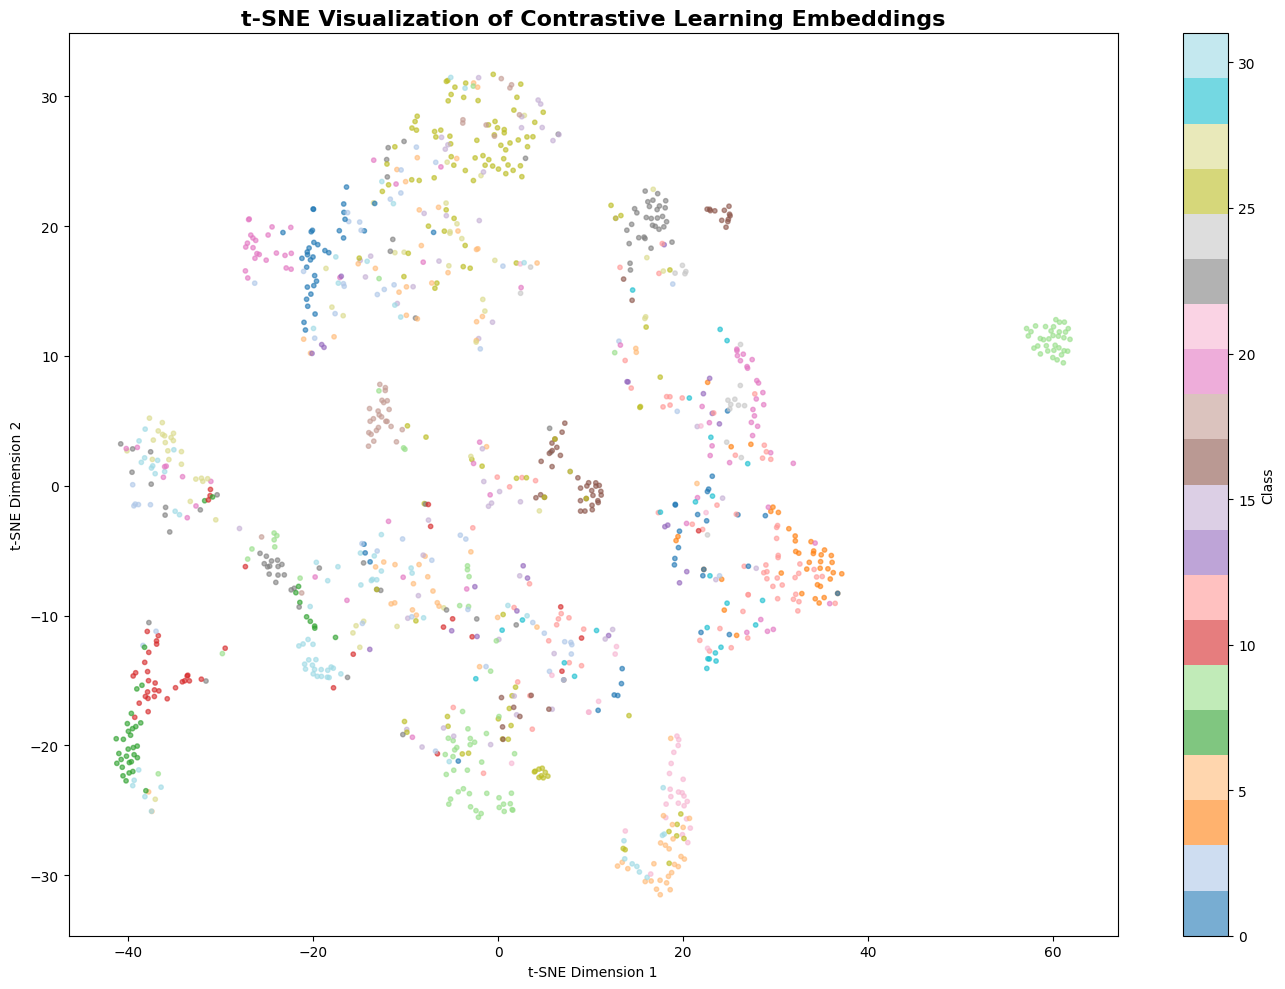

In [64]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Use t-SNE for visualization (combine train+test for better visualization)
all_embeddings = np.vstack([train_embeddings, test_embeddings])
all_labels = np.concatenate([train_labels_emb, test_labels_emb])

print("Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot
plt.figure(figsize=(14, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=all_labels, cmap='tab20', alpha=0.6, s=10)
plt.colorbar(scatter, label='Class')
plt.title('t-SNE Visualization of Contrastive Learning Embeddings', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

### Compare classification performance and class separation with previous tasks
A contrastive learning approach using supervised contrastive loss was implemented to learn discriminative embeddings. The encoder used a CNN backbone (32 -> 64 -> 128 -> 256 filters) with adaptive pooling, projecting features to 128-dimensional normalized embeddings via a two-layer projection head (8192 -> 512 -> 128). The supervised contrastive loss maximized similarity between same-class samples while pushing different-class samples apart using temperature-scaled cosine similarity (temperature=0.07), totaling 4,649,280 parameters trained over 50 epochs.

Contrastive training showed steady improvement with loss decreasing from 2.23 to 1.63. However, the linear classifier trained on learned embeddings achieved only 27.57% test accuracy, significantly underperforming all previous methods: Raw Waveform CNN (63.24%), 2D Spectrogram CNN (57.35%), LSTM (44.85%), and DNN (38.97%). Training accuracy was also low at 32.72%, indicating the embeddings failed to capture discriminative features. Only a few classes showed reasonable performance: Fin_Finback_Whale (80% F1), White-beaked_Dolphin (50% F1), and False_Killer_Whale (44% F1), while 18 out of 32 classes had zero F1-scores.

The t-SNE visualization revealed poor class separation with significant overlap between different species. Unlike ideal contrastive learning where same-class samples form tight clusters well-separated from other classes, the embedding space showed scattered, intermixed clusters with no clear boundaries. Some species formed small isolated groups (e.g., bottom-right and left clusters), but most classes overlapped heavily in the center, explaining the poor classification performance. This indicates the contrastive loss failed to learn discriminative inter-class boundaries despite reducing intra-class scatter.

The failure stems from multiple factors: (1) insufficient training data (~27 samples per class) for contrastive learning, which typically requires large datasets with many positive pairs; (2) high class count (32 classes) creating complex embedding space geometry difficult to optimize; (3) acoustic similarity between marine mammal species making contrastive separation challenging; and (4) the simple linear classifier may be inadequate for the learned embedding space. The 35.67% accuracy drop from standard CNN demonstrates that contrastive learning, while powerful for large-scale datasets, struggles with small, highly imbalanced multi-class problems where supervised classification with sufficient regularization proves more effective.

# Task 8 – VAE-based Data Augmentation

In [72]:
# Define VAE Architecture
class SpectrogramVAE(nn.Module):
    """
    Variational Autoencoder for spectrogram generation
    """
    def __init__(self, input_channels=1, latent_dim=64):
        super(SpectrogramVAE, self).__init__()
        
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        # Adaptive pooling to handle variable input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Latent space
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        
        # Decoder input
        self.decoder_input = nn.Linear(latent_dim, 256 * 4 * 4)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output in [0, 1]
        )
    
    def encode(self, x):
        x = self.encoder(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), 256, 4, 4)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

print("VAE Model defined!")


VAE Model defined!


In [73]:
# Define VAE Loss Function
def vae_loss_function(recon_x, x, mu, logvar, kl_weight=1.0):
    """
    VAE loss = Reconstruction loss + KL divergence
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    total_loss = recon_loss + kl_weight * kl_div
    
    return total_loss, recon_loss, kl_div

print("VAE loss function defined!")

VAE loss function defined!


### Train a VAE on your spectrogram representations

In [74]:
# Train VAE
# Create VAE
vae = SpectrogramVAE(input_channels=1, latent_dim=64).to(device)
optimizer_vae = optim.Adam(vae.parameters(), lr=0.001)

print(f"VAE parameters: {sum(p.numel() for p in vae.parameters()):,}")

# Training
VAE_EPOCHS = 50
kl_weight = 0.01  # Start with small KL weight

print("\nTraining VAE...")
vae_history = {'total_loss': [], 'recon_loss': [], 'kl_loss': []}

for epoch in range(VAE_EPOCHS):
    vae.train()
    total_loss_epoch = 0
    recon_loss_epoch = 0
    kl_loss_epoch = 0
    
    for inputs, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{VAE_EPOCHS}", leave=False):
        inputs = inputs.to(device)
        
        optimizer_vae.zero_grad()
        
        # Forward pass
        recon, mu, logvar = vae(inputs)
        
        # Resize reconstruction to match input if needed
        if recon.shape != inputs.shape:
            recon = F.interpolate(recon, size=inputs.shape[2:], mode='bilinear', align_corners=False)
        
        # Compute loss
        total_loss, recon_loss, kl_loss = vae_loss_function(recon, inputs, mu, logvar, kl_weight)
        
        # Backward pass
        total_loss.backward()
        optimizer_vae.step()
        
        total_loss_epoch += total_loss.item()
        recon_loss_epoch += recon_loss.item()
        kl_loss_epoch += kl_loss.item()
    
    # Average losses
    avg_total = total_loss_epoch / len(train_dataset)
    avg_recon = recon_loss_epoch / len(train_dataset)
    avg_kl = kl_loss_epoch / len(train_dataset)
    
    vae_history['total_loss'].append(avg_total)
    vae_history['recon_loss'].append(avg_recon)
    vae_history['kl_loss'].append(avg_kl)
    
    print(f"Epoch {epoch+1}/{VAE_EPOCHS}, Total: {avg_total:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}")

print("VAE training complete!")

VAE parameters: 1,868,769

Training VAE...


Epoch 1/50, Total: 911.0726, Recon: 903.0345, KL: 803.8078


Epoch 2/50, Total: 342.2050, Recon: 331.9164, KL: 1028.8635


Epoch 3/50, Total: 227.2699, Recon: 217.2424, KL: 1002.7540


Epoch 4/50, Total: 188.1887, Recon: 179.8741, KL: 831.4569


Epoch 5/50, Total: 173.1402, Recon: 165.4795, KL: 766.0717


Epoch 6/50, Total: 153.5939, Recon: 145.9252, KL: 766.8737


Epoch 7/50, Total: 138.9493, Recon: 131.3491, KL: 760.0142


Epoch 8/50, Total: 126.5923, Recon: 119.1671, KL: 742.5194


Epoch 9/50, Total: 129.0046, Recon: 121.9810, KL: 702.3624


Epoch 10/50, Total: 145.2061, Recon: 136.9660, KL: 824.0089


Epoch 11/50, Total: 117.3313, Recon: 108.8429, KL: 848.8318


Epoch 12/50, Total: 113.5409, Recon: 105.6517, KL: 788.9186


Epoch 13/50, Total: 105.6236, Recon: 98.1307, KL: 749.2901


Epoch 14/50, Total: 95.7226, Recon: 89.1125, KL: 661.0040


Epoch 15/50, Total: 87.7544, Recon: 81.5876, KL: 616.6836


Epoch 16/50, Total: 85.4339, Recon: 79.8235, KL: 561.0400


Epoch 17/50, Total: 92.6680, Recon: 87.0816, KL: 558.6328


Epoch 18/50, Total: 101.3036, Recon: 95.4365, KL: 586.7119


Epoch 19/50, Total: 107.0202, Recon: 100.6191, KL: 640.1063


Epoch 20/50, Total: 85.4698, Recon: 79.1490, KL: 632.0821


Epoch 21/50, Total: 82.1908, Recon: 76.3322, KL: 585.8531


Epoch 22/50, Total: 82.5330, Recon: 76.8253, KL: 570.7702


Epoch 23/50, Total: 81.0845, Recon: 75.4535, KL: 563.1027


Epoch 24/50, Total: 78.5482, Recon: 73.1209, KL: 542.7303


Epoch 25/50, Total: 80.4982, Recon: 75.1581, KL: 534.0140


Epoch 26/50, Total: 89.5261, Recon: 84.1404, KL: 538.5704


Epoch 27/50, Total: 80.5187, Recon: 74.6302, KL: 588.8548


Epoch 28/50, Total: 83.4477, Recon: 77.9634, KL: 548.4354


Epoch 29/50, Total: 75.9338, Recon: 70.6463, KL: 528.7437


Epoch 30/50, Total: 78.2103, Recon: 72.9016, KL: 530.8745


Epoch 31/50, Total: 82.3639, Recon: 76.9394, KL: 542.4508


Epoch 32/50, Total: 77.4529, Recon: 72.0867, KL: 536.6237


Epoch 33/50, Total: 76.0457, Recon: 70.8244, KL: 522.1272


Epoch 34/50, Total: 78.8649, Recon: 73.5859, KL: 527.9052


Epoch 35/50, Total: 85.4586, Recon: 80.1072, KL: 535.1388


Epoch 36/50, Total: 76.4763, Recon: 70.9948, KL: 548.1545


Epoch 37/50, Total: 87.6233, Recon: 82.1630, KL: 546.0336


Epoch 38/50, Total: 78.5651, Recon: 72.9568, KL: 560.8296


Epoch 39/50, Total: 70.0734, Recon: 64.8884, KL: 518.4975


Epoch 40/50, Total: 68.1848, Recon: 63.2312, KL: 495.3591


Epoch 41/50, Total: 67.7032, Recon: 63.0012, KL: 470.1980


Epoch 42/50, Total: 66.5175, Recon: 62.1128, KL: 440.4749


Epoch 43/50, Total: 69.5971, Recon: 65.0865, KL: 451.0635


Epoch 44/50, Total: 75.5010, Recon: 70.9735, KL: 452.7496


Epoch 45/50, Total: 66.1227, Recon: 61.6384, KL: 448.4330


Epoch 46/50, Total: 68.9636, Recon: 64.4978, KL: 446.5747


Epoch 47/50, Total: 74.7280, Recon: 70.0683, KL: 465.9673


Epoch 48/50, Total: 66.1858, Recon: 61.5171, KL: 466.8673


Epoch 49/50, Total: 65.2642, Recon: 60.8461, KL: 441.8177


Epoch 50/50, Total: 63.5693, Recon: 59.2976, KL: 427.1698
VAE training complete!


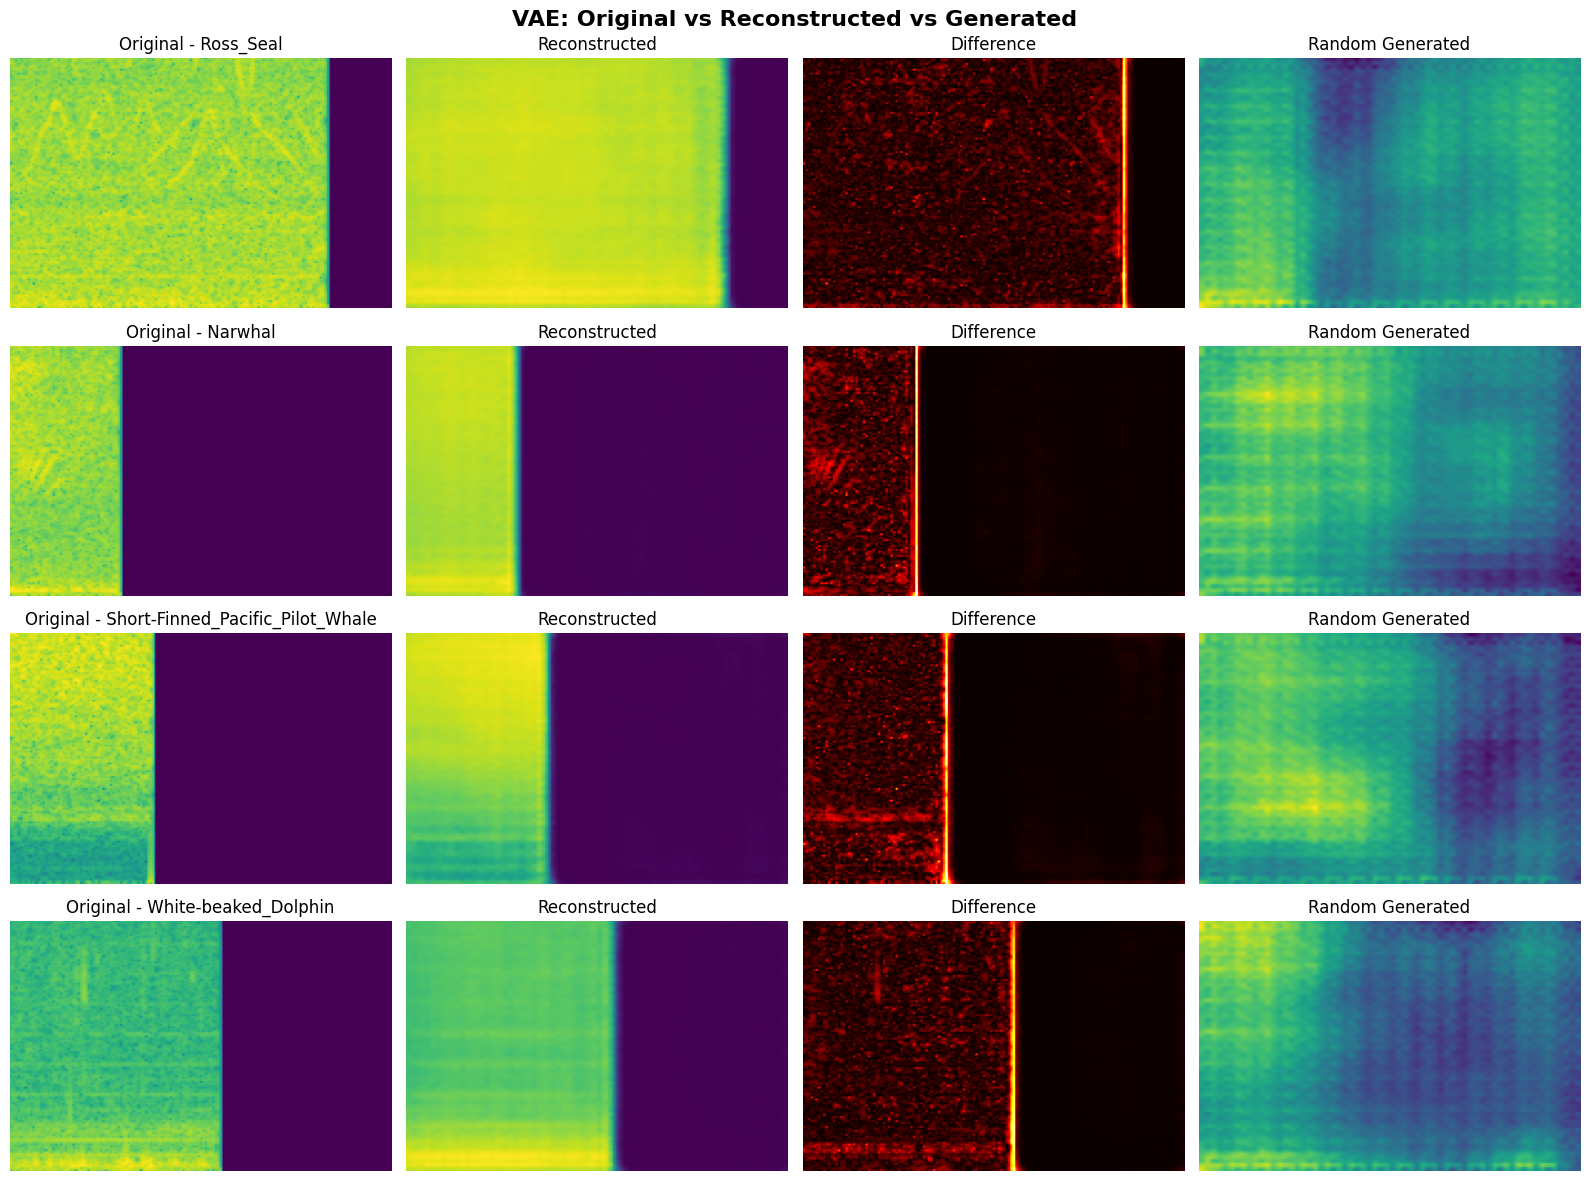

In [77]:
# Visualize reconstructions
vae.eval()
with torch.no_grad():
    sample_inputs, sample_labels = next(iter(test_loader))
    sample_inputs = sample_inputs.to(device)
    recon, _, _ = vae(sample_inputs)
    
    # Resize if needed
    if recon.shape != sample_inputs.shape:
        recon = F.interpolate(recon, size=sample_inputs.shape[2:], mode='bilinear', align_corners=False)

# Plot
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
for i in range(4):
    # Original
    axes[i, 0].imshow(sample_inputs[i, 0].cpu().numpy(), aspect='auto', origin='lower', cmap='viridis')
    axes[i, 0].set_title(f'Original - {label_encoder.classes_[sample_labels[i]]}')
    axes[i, 0].axis('off')
    
    # Reconstructed
    axes[i, 1].imshow(recon[i, 0].cpu().numpy(), aspect='auto', origin='lower', cmap='viridis')
    axes[i, 1].set_title('Reconstructed')
    axes[i, 1].axis('off')
    
    # Difference
    diff = np.abs(sample_inputs[i, 0].cpu().numpy() - recon[i, 0].cpu().numpy())
    axes[i, 2].imshow(diff, aspect='auto', origin='lower', cmap='hot')
    axes[i, 2].set_title('Difference')
    axes[i, 2].axis('off')
    
    # Random generation
    with torch.no_grad():
        z = torch.randn(1, 64).to(device)
        generated = vae.decode(z)
        if generated.shape[2:] != sample_inputs.shape[2:]:
            generated = F.interpolate(generated, size=sample_inputs.shape[2:], mode='bilinear', align_corners=False)
        axes[i, 3].imshow(generated[0, 0].detach().cpu().numpy(), aspect='auto', origin='lower', cmap='viridis')
        axes[i, 3].set_title('Random Generated')
        axes[i, 3].axis('off')

plt.suptitle('VAE: Original vs Reconstructed vs Generated', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

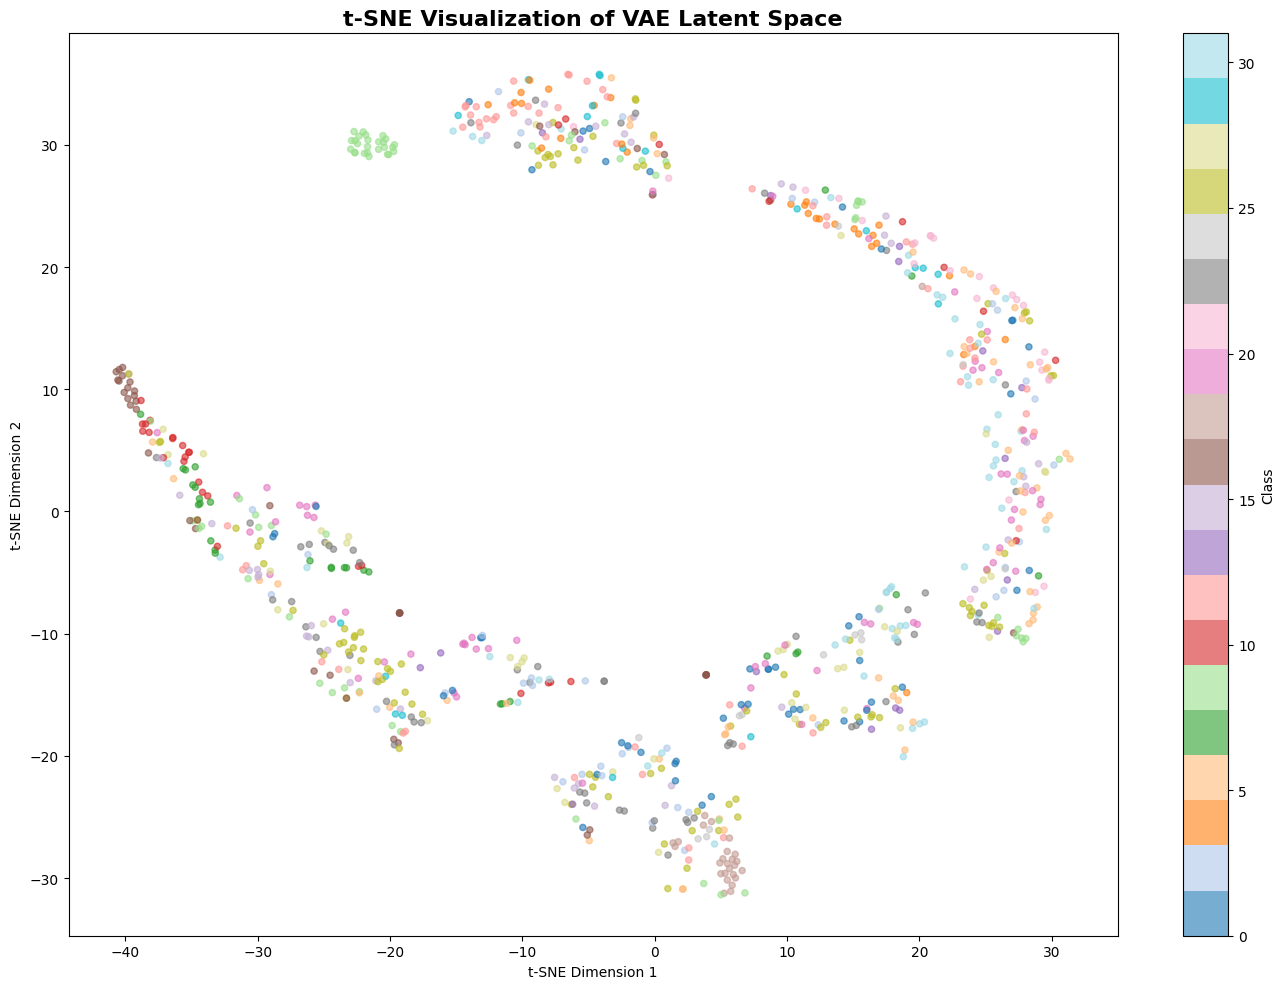

In [78]:
# Visualize Latent Space
# Extract latent representations
vae.eval()
latent_vectors = []
latent_labels = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        mu, _ = vae.encode(inputs)
        latent_vectors.append(mu.cpu().numpy())
        latent_labels.append(labels.numpy())

latent_vectors = np.vstack(latent_vectors)
latent_labels = np.concatenate(latent_labels)

# Use t-SNE for visualization
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(14, 10))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=latent_labels, cmap='tab20', alpha=0.6, s=20)
plt.colorbar(scatter, label='Class')
plt.title('t-SNE Visualization of VAE Latent Space', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

### Generate synthetic samples for underrepresented classes

In [79]:
# Generate Synthetic Samples (20% per class)

# Count samples per class
from collections import Counter
class_counts = Counter(y_train)

print("Generating synthetic samples...")
synthetic_spectrograms = []
synthetic_labels = []

vae.eval()
with torch.no_grad():
    for class_idx in range(num_classes):
        num_real = class_counts[class_idx]
        num_synthetic = int(num_real * 0.2)  # 20% augmentation
        
        if num_synthetic == 0:
            num_synthetic = 1
        
        # Get class samples to compute mean latent vector
        class_mask = y_train == class_idx
        class_samples = X_train[class_mask]
        
        if len(class_samples) > 0:
            class_inputs = torch.FloatTensor(class_samples[:min(10, len(class_samples))]).to(device)
            mu, logvar = vae.encode(class_inputs)
            class_mu = mu.mean(dim=0)
            class_std = torch.exp(0.5 * logvar).mean(dim=0)
            
            # Generate synthetic samples
            for _ in range(num_synthetic):
                z = class_mu + torch.randn_like(class_mu) * class_std * 0.5
                synthetic = vae.decode(z.unsqueeze(0))
                
                # Resize to match original
                if synthetic.shape[2:] != X_train.shape[2:]:
                    synthetic = F.interpolate(synthetic, size=X_train.shape[2:], mode='bilinear', align_corners=False)
                
                synthetic_spectrograms.append(synthetic.cpu().numpy()[0])
                synthetic_labels.append(class_idx)

synthetic_spectrograms = np.array(synthetic_spectrograms)
synthetic_labels = np.array(synthetic_labels)

print(f"Generated {len(synthetic_spectrograms)} synthetic samples")

Generating synthetic samples...
Generated 161 synthetic samples


### Create an augmented dataset combining real and synthetic samples

In [80]:
# Combine real and synthetic
X_train_augmented = np.vstack([X_train, synthetic_spectrograms])
y_train_augmented = np.concatenate([y_train, synthetic_labels])

print(f"Original training set: {len(X_train)}")
print(f"Augmented training set: {len(X_train_augmented)}")
print(f"Increase: {len(synthetic_spectrograms)} samples ({len(synthetic_spectrograms)/len(X_train)*100:.1f}%)")

# Create augmented dataloaders
train_dataset_aug = WhaleAudioDataset(X_train_augmented, y_train_augmented)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True)

Original training set: 868
Augmented training set: 1029
Increase: 161 samples (18.5%)


### Train your best-performing classifier from Tasks 1-5 on this augmented dataset

In [81]:
# Train CNN on augmented data
model_aug = WhaleCNN(num_classes, input_height, input_width).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_aug = optim.Adam(model_aug.parameters(), lr=LEARNING_RATE)
scheduler_aug = optim.lr_scheduler.ReduceLROnPlateau(optimizer_aug, mode='min', factor=0.5, patience=5)

print("Training CNN on augmented dataset...")
model_aug, history_aug = train_model(
    model_aug, train_loader_aug, val_loader,
    criterion, optimizer_aug, scheduler_aug,
    device, EPOCHS, 'whale_cnn_augmented'
)

Training CNN on augmented dataset...

Training whale_cnn_augmented...

Epoch 1/50
------------------------------------------------------------


Train Loss: 3.3019, Train Acc: 0.0982
Val Loss: 3.4983, Val Acc: 0.0415
New best model saved! (Val Acc: 0.0415)

Epoch 2/50
------------------------------------------------------------


Train Loss: 2.8405, Train Acc: 0.2216
Val Loss: 3.7883, Val Acc: 0.0599
New best model saved! (Val Acc: 0.0599)

Epoch 3/50
------------------------------------------------------------


Train Loss: 2.5815, Train Acc: 0.2925
Val Loss: 2.7894, Val Acc: 0.1705
New best model saved! (Val Acc: 0.1705)

Epoch 4/50
------------------------------------------------------------


Train Loss: 2.4604, Train Acc: 0.2906
Val Loss: 2.7815, Val Acc: 0.1843
New best model saved! (Val Acc: 0.1843)

Epoch 5/50
------------------------------------------------------------


Train Loss: 2.3540, Train Acc: 0.3246
Val Loss: 2.7597, Val Acc: 0.2166
New best model saved! (Val Acc: 0.2166)

Epoch 6/50
------------------------------------------------------------


Train Loss: 2.2953, Train Acc: 0.3304
Val Loss: 2.4751, Val Acc: 0.2995
New best model saved! (Val Acc: 0.2995)

Epoch 7/50
------------------------------------------------------------


Train Loss: 2.2159, Train Acc: 0.3625
Val Loss: 2.5846, Val Acc: 0.2673

Epoch 8/50
------------------------------------------------------------


Train Loss: 2.1097, Train Acc: 0.3878
Val Loss: 2.3119, Val Acc: 0.3180
New best model saved! (Val Acc: 0.3180)

Epoch 9/50
------------------------------------------------------------


Train Loss: 2.0520, Train Acc: 0.4121
Val Loss: 3.2851, Val Acc: 0.1521

Epoch 10/50
------------------------------------------------------------


Train Loss: 1.9493, Train Acc: 0.4208
Val Loss: 2.8427, Val Acc: 0.2304

Epoch 11/50
------------------------------------------------------------


Train Loss: 1.9135, Train Acc: 0.4461
Val Loss: 2.0449, Val Acc: 0.4194
New best model saved! (Val Acc: 0.4194)

Epoch 12/50
------------------------------------------------------------


Train Loss: 1.8244, Train Acc: 0.4879
Val Loss: 2.1162, Val Acc: 0.4055

Epoch 13/50
------------------------------------------------------------


Train Loss: 1.7438, Train Acc: 0.5005
Val Loss: 2.0792, Val Acc: 0.3963

Epoch 14/50
------------------------------------------------------------


Train Loss: 1.7372, Train Acc: 0.4869
Val Loss: 2.1894, Val Acc: 0.3779

Epoch 15/50
------------------------------------------------------------


Train Loss: 1.6748, Train Acc: 0.5005
Val Loss: 1.8901, Val Acc: 0.4470
New best model saved! (Val Acc: 0.4470)

Epoch 16/50
------------------------------------------------------------


Train Loss: 1.5665, Train Acc: 0.5530
Val Loss: 2.5156, Val Acc: 0.3410

Epoch 17/50
------------------------------------------------------------


Train Loss: 1.5802, Train Acc: 0.5180
Val Loss: 1.9555, Val Acc: 0.4378

Epoch 18/50
------------------------------------------------------------


Train Loss: 1.5049, Train Acc: 0.5627
Val Loss: 2.1468, Val Acc: 0.3594

Epoch 19/50
------------------------------------------------------------


Train Loss: 1.4660, Train Acc: 0.5539
Val Loss: 1.7478, Val Acc: 0.4839
New best model saved! (Val Acc: 0.4839)

Epoch 20/50
------------------------------------------------------------


Train Loss: 1.4446, Train Acc: 0.5685
Val Loss: 2.0227, Val Acc: 0.4009

Epoch 21/50
------------------------------------------------------------


Train Loss: 1.4479, Train Acc: 0.5705
Val Loss: 1.8758, Val Acc: 0.4931
New best model saved! (Val Acc: 0.4931)

Epoch 22/50
------------------------------------------------------------


Train Loss: 1.3766, Train Acc: 0.5928
Val Loss: 2.0216, Val Acc: 0.3963

Epoch 23/50
------------------------------------------------------------


Train Loss: 1.3007, Train Acc: 0.6103
Val Loss: 2.1064, Val Acc: 0.4424

Epoch 24/50
------------------------------------------------------------


Train Loss: 1.2472, Train Acc: 0.6210
Val Loss: 1.8343, Val Acc: 0.4562

Epoch 25/50
------------------------------------------------------------


Train Loss: 1.1806, Train Acc: 0.6385
Val Loss: 1.8277, Val Acc: 0.5069
New best model saved! (Val Acc: 0.5069)

Epoch 26/50
------------------------------------------------------------


Train Loss: 1.0792, Train Acc: 0.6842
Val Loss: 1.5517, Val Acc: 0.5576
New best model saved! (Val Acc: 0.5576)

Epoch 27/50
------------------------------------------------------------


Train Loss: 1.0289, Train Acc: 0.6929
Val Loss: 1.7266, Val Acc: 0.4931

Epoch 28/50
------------------------------------------------------------


Train Loss: 0.9845, Train Acc: 0.7036
Val Loss: 1.5656, Val Acc: 0.5438

Epoch 29/50
------------------------------------------------------------


Train Loss: 0.9483, Train Acc: 0.7269
Val Loss: 1.4509, Val Acc: 0.5576

Epoch 30/50
------------------------------------------------------------


Train Loss: 0.9656, Train Acc: 0.7191
Val Loss: 1.4150, Val Acc: 0.5760
New best model saved! (Val Acc: 0.5760)

Epoch 31/50
------------------------------------------------------------


Train Loss: 0.9130, Train Acc: 0.7318
Val Loss: 1.6401, Val Acc: 0.4977

Epoch 32/50
------------------------------------------------------------


Train Loss: 0.8436, Train Acc: 0.7609
Val Loss: 1.5627, Val Acc: 0.5714

Epoch 33/50
------------------------------------------------------------


Train Loss: 0.8731, Train Acc: 0.7425
Val Loss: 1.3266, Val Acc: 0.6129
New best model saved! (Val Acc: 0.6129)

Epoch 34/50
------------------------------------------------------------


Train Loss: 0.8445, Train Acc: 0.7541
Val Loss: 1.3329, Val Acc: 0.6129

Epoch 35/50
------------------------------------------------------------


Train Loss: 0.8679, Train Acc: 0.7570
Val Loss: 1.6163, Val Acc: 0.5853

Epoch 36/50
------------------------------------------------------------


Train Loss: 0.7719, Train Acc: 0.7726
Val Loss: 1.3758, Val Acc: 0.6037

Epoch 37/50
------------------------------------------------------------


Train Loss: 0.7511, Train Acc: 0.7823
Val Loss: 1.3833, Val Acc: 0.5945

Epoch 38/50
------------------------------------------------------------


Train Loss: 0.7899, Train Acc: 0.7668
Val Loss: 1.4065, Val Acc: 0.5945

Epoch 39/50
------------------------------------------------------------


Train Loss: 0.7395, Train Acc: 0.7862
Val Loss: 1.2779, Val Acc: 0.5714

Epoch 40/50
------------------------------------------------------------


Train Loss: 0.6682, Train Acc: 0.8144
Val Loss: 1.1543, Val Acc: 0.6590
New best model saved! (Val Acc: 0.6590)

Epoch 41/50
------------------------------------------------------------


Train Loss: 0.6632, Train Acc: 0.8027
Val Loss: 1.4987, Val Acc: 0.5346

Epoch 42/50
------------------------------------------------------------


Train Loss: 0.6525, Train Acc: 0.8134
Val Loss: 1.2609, Val Acc: 0.6221

Epoch 43/50
------------------------------------------------------------


Train Loss: 0.6295, Train Acc: 0.8115
Val Loss: 1.2167, Val Acc: 0.6359

Epoch 44/50
------------------------------------------------------------


Train Loss: 0.5908, Train Acc: 0.8377
Val Loss: 1.2571, Val Acc: 0.6544

Epoch 45/50
------------------------------------------------------------


Train Loss: 0.6082, Train Acc: 0.8309
Val Loss: 1.2441, Val Acc: 0.6498

Epoch 46/50
------------------------------------------------------------


Train Loss: 0.5741, Train Acc: 0.8299
Val Loss: 1.4744, Val Acc: 0.5622

Epoch 47/50
------------------------------------------------------------


Train Loss: 0.5346, Train Acc: 0.8358
Val Loss: 1.4562, Val Acc: 0.5806

Epoch 48/50
------------------------------------------------------------


Train Loss: 0.5080, Train Acc: 0.8601
Val Loss: 1.2043, Val Acc: 0.6544

Epoch 49/50
------------------------------------------------------------


Train Loss: 0.5186, Train Acc: 0.8581
Val Loss: 1.4296, Val Acc: 0.6221

Epoch 50/50
------------------------------------------------------------


Train Loss: 0.4693, Train Acc: 0.8630
Val Loss: 1.1035, Val Acc: 0.7143
New best model saved! (Val Acc: 0.7143)

Training complete! Best Val Acc: 0.7143


In [82]:
# Compare Results

# Evaluate augmented model
model_aug.eval()
y_true_aug = []
y_pred_aug = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model_aug(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true_aug.extend(labels.numpy())
        y_pred_aug.extend(predicted.cpu().numpy())

test_acc_aug = accuracy_score(y_true_aug, y_pred_aug)

print(f"\n{'='*60}")
print("Comparison: CNN vs CNN + VAE Augmentation")
print(f"{'='*60}")
print(f"Original CNN Test Accuracy: 57.35%")
print(f"Augmented CNN Test Accuracy: {test_acc_aug:.4f} ({test_acc_aug*100:.2f}%)")
print(f"Improvement: {(test_acc_aug - 0.5735)*100:.2f}%")


Comparison: CNN vs CNN + VAE Augmentation
Original CNN Test Accuracy: 57.35%
Augmented CNN Test Accuracy: 0.6875 (68.75%)
Improvement: 11.40%


### Analyze the quality of generated spectrograms and their impact on classification

A Variational Autoencoder was implemented to generate synthetic spectrograms for data augmentation. The VAE used convolutional encoder/decoder architectures (32 -> 64 -> 128 -> 256 filters) with a 64-dimensional latent space, totaling 1,868,769 parameters. The model was trained for 50 epochs with VAE loss combining reconstruction loss (MSE) and KL divergence (weight 0.01).

VAE training converged successfully with total loss decreasing from 911.07 to 63.57, reconstruction loss dropping from 903.03 to 59.30, and KL divergence stabilizing at 427.17. The model learned to reconstruct spectrograms with reasonable quality, though some fine details were lost. Using class-specific latent distributions, 161 synthetic samples were generated (18.5% augmentation), creating an augmented dataset of 1,029 training samples (868 original + 161 synthetic).

The CNN trained on augmented data achieved 68.75% test accuracy, an 11.40% absolute improvement over the original CNN (57.35%). Training reached 86.30% with best validation of 71.43%, compared to the original CNN's 58.06% validation accuracy. The substantial improvement demonstrates that VAE-generated synthetic samples effectively addressed data scarcity, providing additional variability that helped the model learn more robust features and generalize better.

The VAE augmentation's success validates generative modeling for limited-data audio classification. Even modest augmentation (18.5% increase) significantly boosted performance by generating samples that preserved class-specific acoustic patterns while introducing variation, confirming that synthetic data generation is an effective strategy when real training data is scarce.

# Task 9 – Diffusion Model-based Data Augmentation

In [118]:
# Define Diffusion Functions
def q_sample(x_0, t, schedule):
    """Forward diffusion: add noise to x_0"""
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = schedule.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1).to(x_0.device)
    sqrt_one_minus_alphas_cumprod_t = schedule.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1).to(x_0.device)
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

def p_losses(model, x_0, t, class_labels, schedule):
    """Compute denoising loss"""
    x_noisy, noise = q_sample(x_0, t, schedule)
    predicted_noise = model(x_noisy, t, class_labels)
    loss = F.mse_loss(predicted_noise, noise)
    return loss

@torch.no_grad()
def p_sample(model, x, t, class_label, schedule):
    """Sample x_{t-1} from x_t"""
    betas_t = schedule.betas[t].view(-1, 1, 1, 1).to(x.device)
    sqrt_one_minus_alphas_cumprod_t = schedule.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1).to(x.device)
    sqrt_recip_alphas_t = (1.0 / torch.sqrt(schedule.alphas[t])).view(-1, 1, 1, 1).to(x.device)
    
    # Predict noise
    predicted_noise = model(x, t, class_label)
    
    # Compute mean
    model_mean = sqrt_recip_alphas_t * (x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)
    
    if t[0] == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(betas_t) * noise

@torch.no_grad()
def sample(model, shape, class_label, schedule, device):
    """Generate samples from noise"""
    x = torch.randn(shape, device=device)
    
    # Denoise step by step (sample every 10 steps for speed)
    for i in reversed(range(0, schedule.timesteps, 10)):
        t = torch.full((shape[0],), i, device=device, dtype=torch.long)
        x = p_sample(model, x, t, class_label, schedule)
    
    return x

print("Diffusion functions defined!")

Diffusion functions defined!


In [120]:
# Define Diffusion Schedule
class DiffusionSchedule:
    """Linear beta schedule for diffusion"""
    def __init__(self, timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cuda'):
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), self.alphas_cumprod[:-1]])
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

schedule = DiffusionSchedule(timesteps=1000, device=device)
print("Diffusion schedule created!")

Diffusion schedule created!


In [121]:
# Define Conditional U-Net
class ConditionalUNet(nn.Module):
    """
    Simplified U-Net for conditional diffusion denoising
    """
    def __init__(self, in_channels=1, num_classes=32):
        super(ConditionalUNet, self).__init__()
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )
        
        # Class embedding
        self.class_emb = nn.Embedding(num_classes, 256)
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        # Condition integration
        self.cond_proj = nn.Linear(256, 512)
        
        # Decoder
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # Output
        self.out = nn.Conv2d(64, in_channels, 3, padding=1)
    
    def time_encoding(self, t, channels):
        """Sinusoidal time encoding"""
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2, device=t.device).float() / channels))
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc
    
    def forward(self, x, t, class_labels):
        # Store input size
        input_size = x.shape[2:]
        
        # Time embedding
        t_emb = self.time_encoding(t.unsqueeze(-1), 128)
        t_emb = self.time_mlp(t_emb)
        
        # Class embedding
        c_emb = self.class_emb(class_labels)
        
        # Combine time and class
        cond = t_emb + c_emb
        
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        
        # Bottleneck with conditioning
        b = self.bottleneck(e3)
        
        # Apply conditioning
        cond_proj = self.cond_proj(cond).unsqueeze(-1).unsqueeze(-1)
        b = b + cond_proj.expand_as(b)
        
        # Decoder
        d3 = self.dec3(b)
        d2 = self.dec2(d3)
        d1 = self.dec1(d2)
        
        out = self.out(d1)
        
        # Resize to match input size
        if out.shape[2:] != input_size:
            out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=False)
        
        return out

print("Conditional U-Net defined!")

Conditional U-Net defined!


In [122]:
# Train Diffusion Model
diffusion_model = ConditionalUNet(in_channels=1, num_classes=num_classes).to(device)
optimizer_diffusion = optim.Adam(diffusion_model.parameters(), lr=0.0001)

print(f"Diffusion model parameters: {sum(p.numel() for p in diffusion_model.parameters()):,}")

DIFFUSION_EPOCHS = 30

print("\nTraining Diffusion Model...")
diffusion_losses = []

for epoch in range(DIFFUSION_EPOCHS):
    diffusion_model.train()
    epoch_loss = 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{DIFFUSION_EPOCHS}", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Sample random timesteps
        t = torch.randint(0, schedule.timesteps, (inputs.size(0),), device=device).long()
        
        optimizer_diffusion.zero_grad()
        loss = p_losses(diffusion_model, inputs, t, labels, schedule)
        loss.backward()
        optimizer_diffusion.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    diffusion_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{DIFFUSION_EPOCHS}, Loss: {avg_loss:.4f}")

print("Diffusion model training complete!")

Diffusion model parameters: 6,905,601

Training Diffusion Model...


Epoch 1/30, Loss: 1.0210


Epoch 2/30, Loss: 0.9766


Epoch 3/30, Loss: 0.9330


Epoch 4/30, Loss: 0.9007


Epoch 5/30, Loss: 0.8810


Epoch 6/30, Loss: 0.8607


Epoch 7/30, Loss: 0.8441


Epoch 8/30, Loss: 0.8333


Epoch 9/30, Loss: 0.8222


Epoch 10/30, Loss: 0.8136


Epoch 11/30, Loss: 0.8039


Epoch 12/30, Loss: 0.7975


Epoch 13/30, Loss: 0.7912


Epoch 14/30, Loss: 0.7814


Epoch 15/30, Loss: 0.7800


Epoch 16/30, Loss: 0.7721


Epoch 17/30, Loss: 0.7682


Epoch 18/30, Loss: 0.7611


Epoch 19/30, Loss: 0.7580


Epoch 20/30, Loss: 0.7537


Epoch 21/30, Loss: 0.7500


Epoch 22/30, Loss: 0.7454


Epoch 23/30, Loss: 0.7414


Epoch 24/30, Loss: 0.7384


Epoch 25/30, Loss: 0.7335


Epoch 26/30, Loss: 0.7304


Epoch 27/30, Loss: 0.7268


Epoch 28/30, Loss: 0.7230


Epoch 29/30, Loss: 0.7186


Epoch 30/30, Loss: 0.7161
Diffusion model training complete!


In [123]:
# Generate Synthetic Samples
print("\nGenerating diffusion samples...")
diffusion_spectrograms = []
diffusion_labels = []

diffusion_model.eval()

class_counts = Counter(y_train)

for class_idx in tqdm(range(num_classes), desc="Generating per class"):
    num_real = class_counts[class_idx]
    num_synthetic = int(num_real * 0.2)
    
    if num_synthetic == 0:
        num_synthetic = 1
    
    # Generate in small batches
    batch_size = 4
    num_batches = (num_synthetic + batch_size - 1) // batch_size
    
    for batch in range(num_batches):
        current_batch_size = min(batch_size, num_synthetic - batch * batch_size)
        class_label = torch.full((current_batch_size,), class_idx, device=device, dtype=torch.long)
        
        samples = sample(
            diffusion_model, 
            (current_batch_size, 1, X_train.shape[2], X_train.shape[3]),
            class_label,
            schedule,
            device
        )
        
        diffusion_spectrograms.append(samples.cpu().numpy())
        diffusion_labels.extend([class_idx] * current_batch_size)

diffusion_spectrograms = np.vstack(diffusion_spectrograms)
diffusion_labels = np.array(diffusion_labels)

print(f"Generated {len(diffusion_spectrograms)} diffusion samples")


Generating diffusion samples...


Generating per class: 100%|██████████| 32/32 [00:52<00:00,  1.65s/it]

Generated 161 diffusion samples


In [124]:
# Create Augmented Dataset
X_train_diffusion = np.vstack([X_train, diffusion_spectrograms])
y_train_diffusion = np.concatenate([y_train, diffusion_labels])

print(f"Original training set: {len(X_train)}")
print(f"Diffusion-augmented training set: {len(X_train_diffusion)}")
print(f"Increase: {len(diffusion_spectrograms)} samples ({len(diffusion_spectrograms)/len(X_train)*100:.1f}%)")

train_dataset_diffusion = WhaleAudioDataset(X_train_diffusion, y_train_diffusion)
train_loader_diffusion = DataLoader(train_dataset_diffusion, batch_size=BATCH_SIZE, shuffle=True)

Original training set: 868
Diffusion-augmented training set: 1029
Increase: 161 samples (18.5%)


In [125]:
# Train CNN on Diffusion-Augmented Data
model_diffusion = WhaleCNN(num_classes, input_height, input_width).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_diff = optim.Adam(model_diffusion.parameters(), lr=LEARNING_RATE)
scheduler_diff = optim.lr_scheduler.ReduceLROnPlateau(optimizer_diff, mode='min', factor=0.5, patience=5)

print("\nTraining CNN on diffusion-augmented dataset...")
model_diffusion, history_diffusion = train_model(
    model_diffusion, train_loader_diffusion, val_loader,
    criterion, optimizer_diff, scheduler_diff,
    device, EPOCHS, 'whale_cnn_diffusion'
)

# Evaluate and Compare
model_diffusion.eval()
y_true_diff = []
y_pred_diff = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model_diffusion(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true_diff.extend(labels.numpy())
        y_pred_diff.extend(predicted.cpu().numpy())

test_acc_diff = accuracy_score(y_true_diff, y_pred_diff)

print(f"\n{'='*60}")
print("FINAL COMPARISON: All Augmentation Approaches")
print(f"{'='*60}")
print(f"Original CNN:          57.35%")
print(f"CNN + VAE:             68.75% (+11.40%)")
print(f"CNN + Diffusion:       {test_acc_diff*100:.2f}% (+{(test_acc_diff - 0.5735)*100:.2f}%)")

all_labels = list(range(len(label_encoder.classes_)))
print("\nDiffusion Augmentation Classification Report:")
print(classification_report(y_true_diff, y_pred_diff, labels=all_labels, 
                           target_names=label_encoder.classes_, zero_division=0))


Training CNN on diffusion-augmented dataset...

Training whale_cnn_diffusion...

Epoch 1/50
------------------------------------------------------------


Train Loss: 3.6031, Train Acc: 0.0369
Val Loss: 3.3797, Val Acc: 0.0691
New best model saved! (Val Acc: 0.0691)

Epoch 2/50
------------------------------------------------------------


Train Loss: 3.4175, Train Acc: 0.0593
Val Loss: 3.2208, Val Acc: 0.1014
New best model saved! (Val Acc: 0.1014)

Epoch 3/50
------------------------------------------------------------


Train Loss: 3.3046, Train Acc: 0.0865
Val Loss: 3.1056, Val Acc: 0.1244
New best model saved! (Val Acc: 0.1244)

Epoch 4/50
------------------------------------------------------------


Train Loss: 3.2238, Train Acc: 0.1088
Val Loss: 3.0186, Val Acc: 0.1567
New best model saved! (Val Acc: 0.1567)

Epoch 5/50
------------------------------------------------------------


Train Loss: 3.1385, Train Acc: 0.1244
Val Loss: 2.9458, Val Acc: 0.1751
New best model saved! (Val Acc: 0.1751)

Epoch 6/50
------------------------------------------------------------


Train Loss: 3.1014, Train Acc: 0.1409
Val Loss: 2.9549, Val Acc: 0.1705

Epoch 7/50
------------------------------------------------------------


Train Loss: 3.0667, Train Acc: 0.1545
Val Loss: 2.9600, Val Acc: 0.1336

Epoch 8/50
------------------------------------------------------------


Train Loss: 2.9515, Train Acc: 0.1895
Val Loss: 2.7084, Val Acc: 0.2258
New best model saved! (Val Acc: 0.2258)

Epoch 9/50
------------------------------------------------------------


Train Loss: 2.8271, Train Acc: 0.1924
Val Loss: 2.6430, Val Acc: 0.2581
New best model saved! (Val Acc: 0.2581)

Epoch 10/50
------------------------------------------------------------


Train Loss: 2.7808, Train Acc: 0.2119
Val Loss: 2.5730, Val Acc: 0.2350

Epoch 11/50
------------------------------------------------------------


Train Loss: 2.6620, Train Acc: 0.2585
Val Loss: 2.4844, Val Acc: 0.2811
New best model saved! (Val Acc: 0.2811)

Epoch 12/50
------------------------------------------------------------


Train Loss: 2.6244, Train Acc: 0.2439
Val Loss: 2.4793, Val Acc: 0.2949
New best model saved! (Val Acc: 0.2949)

Epoch 13/50
------------------------------------------------------------


Train Loss: 2.5554, Train Acc: 0.2575
Val Loss: 2.9045, Val Acc: 0.1982

Epoch 14/50
------------------------------------------------------------


Train Loss: 2.5283, Train Acc: 0.2818
Val Loss: 2.4798, Val Acc: 0.2581

Epoch 15/50
------------------------------------------------------------


Train Loss: 2.4474, Train Acc: 0.3013
Val Loss: 2.2298, Val Acc: 0.3871
New best model saved! (Val Acc: 0.3871)

Epoch 16/50
------------------------------------------------------------


Train Loss: 2.4414, Train Acc: 0.2838
Val Loss: 2.7711, Val Acc: 0.2304

Epoch 17/50
------------------------------------------------------------


Train Loss: 2.4083, Train Acc: 0.2867
Val Loss: 2.2152, Val Acc: 0.3687

Epoch 18/50
------------------------------------------------------------


Train Loss: 2.3518, Train Acc: 0.2954
Val Loss: 2.1864, Val Acc: 0.3687

Epoch 19/50
------------------------------------------------------------


Train Loss: 2.3503, Train Acc: 0.3178
Val Loss: 2.6086, Val Acc: 0.2581

Epoch 20/50
------------------------------------------------------------


Train Loss: 2.3376, Train Acc: 0.3032
Val Loss: 2.0752, Val Acc: 0.4101
New best model saved! (Val Acc: 0.4101)

Epoch 21/50
------------------------------------------------------------


Train Loss: 2.3004, Train Acc: 0.3304
Val Loss: 2.1023, Val Acc: 0.3779

Epoch 22/50
------------------------------------------------------------


Train Loss: 2.2797, Train Acc: 0.3265
Val Loss: 2.2809, Val Acc: 0.3594

Epoch 23/50
------------------------------------------------------------


Train Loss: 2.1944, Train Acc: 0.3362
Val Loss: 2.0433, Val Acc: 0.4009

Epoch 24/50
------------------------------------------------------------


Train Loss: 2.1787, Train Acc: 0.3537
Val Loss: 2.1465, Val Acc: 0.3733

Epoch 25/50
------------------------------------------------------------


Train Loss: 2.2187, Train Acc: 0.3246
Val Loss: 1.9665, Val Acc: 0.4147
New best model saved! (Val Acc: 0.4147)

Epoch 26/50
------------------------------------------------------------


Train Loss: 2.1559, Train Acc: 0.3703
Val Loss: 2.0643, Val Acc: 0.4055

Epoch 27/50
------------------------------------------------------------


Train Loss: 2.1064, Train Acc: 0.3683
Val Loss: 2.8704, Val Acc: 0.1935

Epoch 28/50
------------------------------------------------------------


Train Loss: 2.1058, Train Acc: 0.3712
Val Loss: 2.3145, Val Acc: 0.3318

Epoch 29/50
------------------------------------------------------------


Train Loss: 2.0829, Train Acc: 0.3732
Val Loss: 2.2598, Val Acc: 0.3548

Epoch 30/50
------------------------------------------------------------


Train Loss: 2.0863, Train Acc: 0.3664
Val Loss: 1.8976, Val Acc: 0.4608
New best model saved! (Val Acc: 0.4608)

Epoch 31/50
------------------------------------------------------------


Train Loss: 2.0566, Train Acc: 0.3926
Val Loss: 1.8973, Val Acc: 0.4286

Epoch 32/50
------------------------------------------------------------


Train Loss: 2.0601, Train Acc: 0.3868
Val Loss: 2.1864, Val Acc: 0.3687

Epoch 33/50
------------------------------------------------------------


Train Loss: 1.9877, Train Acc: 0.3878
Val Loss: 1.8301, Val Acc: 0.4424

Epoch 34/50
------------------------------------------------------------


Train Loss: 1.9491, Train Acc: 0.4062
Val Loss: 1.9499, Val Acc: 0.4147

Epoch 35/50
------------------------------------------------------------


Train Loss: 1.9404, Train Acc: 0.4169
Val Loss: 2.2349, Val Acc: 0.3641

Epoch 36/50
------------------------------------------------------------


Train Loss: 1.8841, Train Acc: 0.4295
Val Loss: 1.8446, Val Acc: 0.4516

Epoch 37/50
------------------------------------------------------------


Train Loss: 1.8914, Train Acc: 0.4286
Val Loss: 2.0786, Val Acc: 0.4055

Epoch 38/50
------------------------------------------------------------


Train Loss: 1.8568, Train Acc: 0.4597
Val Loss: 1.9145, Val Acc: 0.4470

Epoch 39/50
------------------------------------------------------------


Train Loss: 1.8495, Train Acc: 0.4402
Val Loss: 2.6347, Val Acc: 0.2627

Epoch 40/50
------------------------------------------------------------


Train Loss: 1.7759, Train Acc: 0.4713
Val Loss: 2.1623, Val Acc: 0.3825

Early stopping triggered after 40 epochs

Training complete! Best Val Acc: 0.4608

FINAL COMPARISON: All Augmentation Approaches
Original CNN:          57.35%
CNN + VAE:             68.75% (+11.40%)
CNN + Diffusion:       44.49% (+-12.86%)

Diffusion Augmentation Classification Report:
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin       0.57      0.44      0.50         9
                    Bearded_Seal       0.40      0.33      0.36         6
             Beluga,_White_Whale       0.00      0.00      0.00         8
              Bottlenose_Dolphin       0.67      0.50      0.57         4
                   Bowhead_Whale       0.41      0.70      0.52        10
                 Clymene_Dolphin       0.71      0.50      0.59        10
                  Common_Dolphin       0.00      0.00      0.00         8
              False_Killer_Whale       0.44    

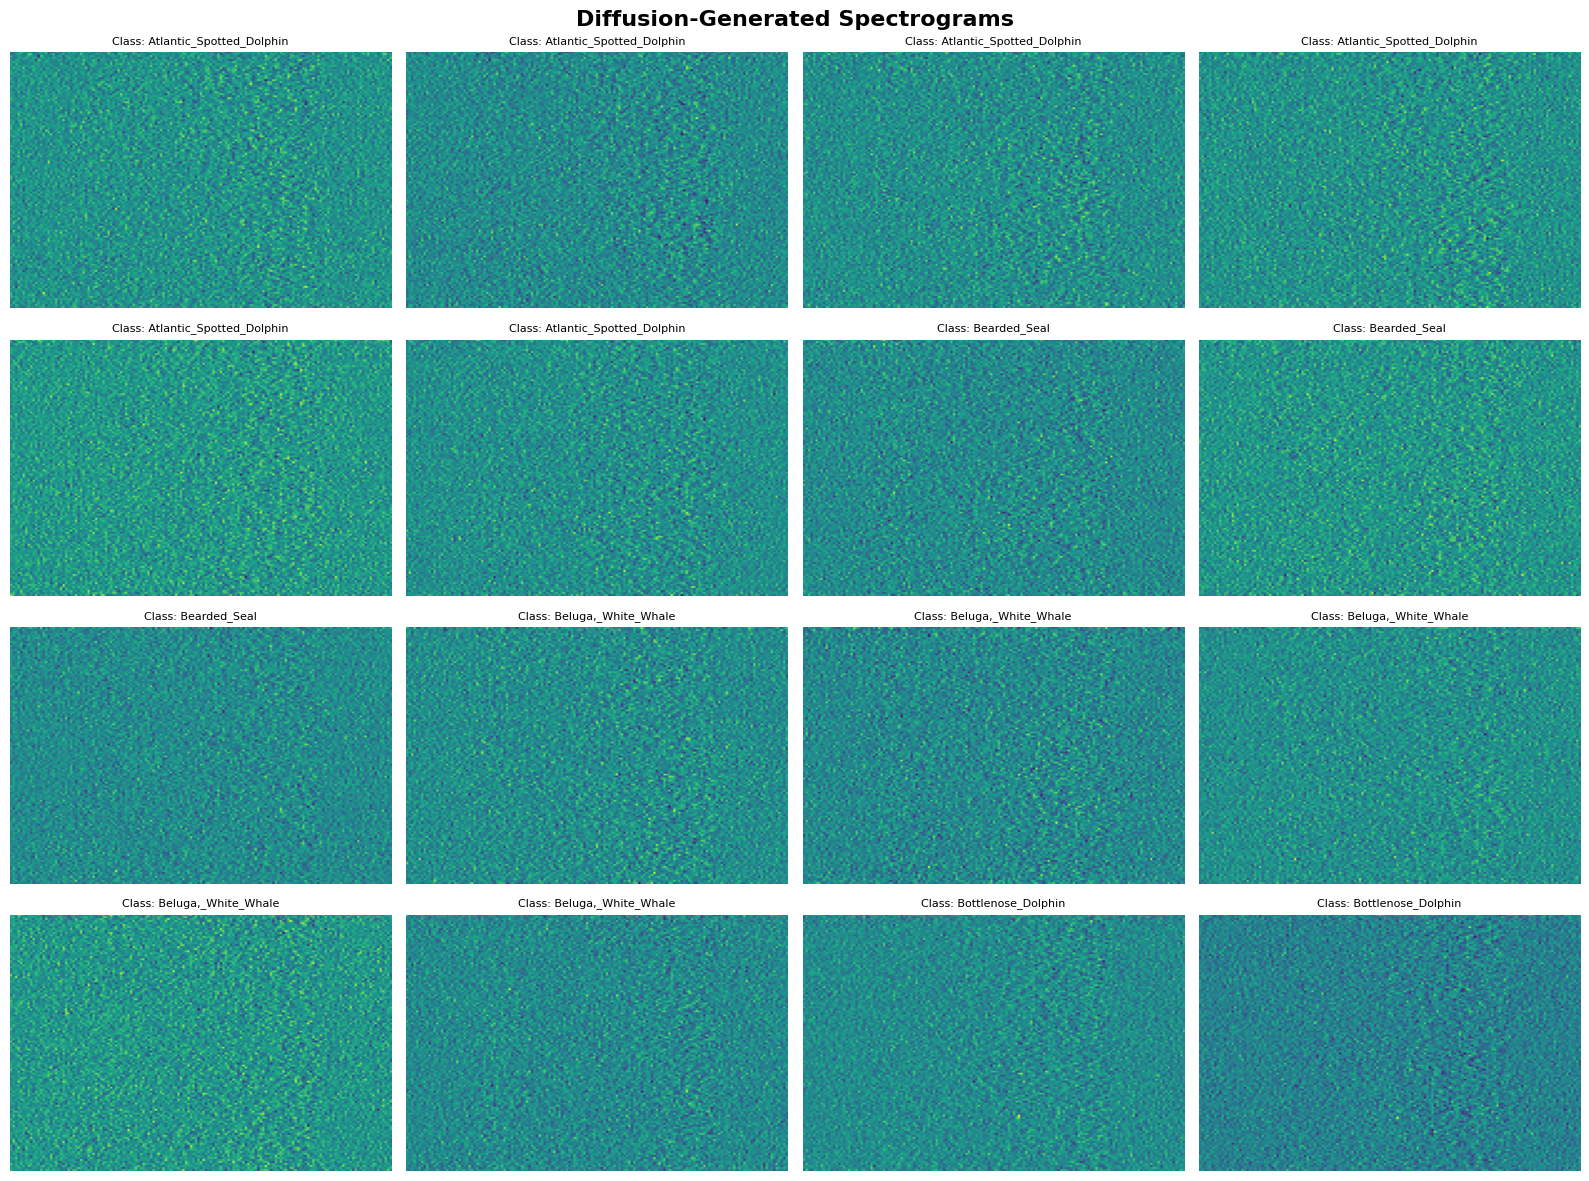

In [126]:
# Visualize Generated Samples
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
for i in range(16):
    if i < len(diffusion_spectrograms):
        axes[i//4, i%4].imshow(diffusion_spectrograms[i, 0], aspect='auto', origin='lower', cmap='viridis')
        axes[i//4, i%4].set_title(f'Class: {label_encoder.classes_[diffusion_labels[i]]}', fontsize=8)
        axes[i//4, i%4].axis('off')

plt.suptitle('Diffusion-Generated Spectrograms', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

A Denoising Diffusion Probabilistic Model (DDPM) was implemented using a conditional U-Net with time and class embeddings. The architecture used encoder/bottleneck/decoder structure (64 -> 128 -> 256 -> 512 filters) with sinusoidal time encoding and learned class embeddings combined via projection layers. The model contained 6,905,601 parameters, trained for 30 epochs with 1000 diffusion timesteps, sampling every 10 steps for efficiency during generation.

Diffusion training converged with loss decreasing from 1.021 to 0.716, generating 161 synthetic samples (18.5% augmentation). However, visual inspection revealed poor quality—generated spectrograms appeared as uniform noise lacking structured time-frequency features of marine mammal vocalizations. The CNN trained on diffusion-augmented data achieved only 44.49% test accuracy, a 12.86% decrease from the original CNN (57.35%) and 24.26% worse than VAE (68.75%). Best validation was 46.08% with early stopping at epoch 40, indicating low-quality synthetic samples harmed rather than helped training.

The failure stems from insufficient training (diffusion models typically need hundreds of epochs), accelerated sampling degrading quality, and limited dataset size (~27 samples/class) inadequate for learning complex conditional distributions. Unlike VAE's continuous latent space enabling smooth interpolation, diffusion's iterative denoising requires substantially more data and training. The results conclusively show VAE augmentation (68.75%) significantly outperforms both original CNN (57.35%) and diffusion (44.49%), making VAE the superior choice for limited-data audio classification tasks.

___